# Import packages

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import sys
import forceatlas2
from fa2 import ForceAtlas2
import igraph
import cairocffi
import scipy

from matplotlib.cm import get_cmap

# Define custom functions

In [2]:
from utils import *

# Import data

## Estimated networks

In [3]:
# Parameters
date = "2020-12-31" #"2020-12-23" or "2020-09-30" or "2020-06-30" or "2020-03-16" or "2019-12-31"
ts_type = "return"
base_path = "./Data/Large_network/Estimated_networks/largenet_"
data_type = "largenet"

# Iterables
methods = ['NS','SPACE','GLASSO','DY','DY_net','DAG']

# Create dictionary to store the outputs
networks = {}

for method in methods:
    
    networks[method] = network_preprocessing_general(date,method,ts_type,base_path)

## Variable names

In [4]:
df = pd.read_csv('./Data/Large_network/largenet_log_ret.csv',sep=",", header=0)

print(df.head())

         Date       JPM       BAC         C       WFC        GS        MS  \
0  2012-01-03  0.000739  0.000788  0.000415  0.000175  0.000497  0.000758   
1  2012-01-04  0.006315  0.001722 -0.005664  0.004562 -0.006523 -0.008744   
2  2012-01-05  0.020672  0.082555  0.011998  0.015978 -0.001690  0.021106   
3  2012-01-06 -0.009010 -0.020817  0.001402 -0.002760 -0.012341 -0.023619   
4  2012-01-09 -0.001698  0.014458  0.018394  0.012363  0.013503  0.018692   

         BK       USB       PNC  ...  BANKBARODA.NS    D05.SI    U11.SI  \
0  0.000406  0.000389  0.000577  ...       0.046850  0.000559  0.000369   
1  0.003407 -0.000363  0.003213  ...       0.001142  0.013582  0.010873   
2  0.008226  0.014762  0.009914  ...      -0.009243 -0.005072 -0.005742   
3 -0.014563 -0.008254  0.001670  ...       0.010953  0.005072 -0.014176   
4  0.020809  0.017504  0.008146  ...      -0.009155 -0.008468 -0.016356   

     EBS.VI  DANSKE.CO   INGA.AS    DNB.OL   SBER.ME  ISCTR.IS    SBK.JO  
0  0.000359

In [5]:
var_names = list(df.columns)[1:]

print(var_names)

['JPM', 'BAC', 'C', 'WFC', 'GS', 'MS', 'BK', 'USB', 'PNC', 'COF', 'STT', 'AXP', 'FITB', 'RF', '8306.T', '8411.T', '8316.T', '8308.T', '8604.T', '8309.T', '8331.T', '8377.T', '8355.T', '8418.T', 'TD.TO', 'RY.TO', 'BNS.TO', 'BMO.TO', 'CM.TO', 'NA.TO', 'UCG.MI', 'ISP.MI', 'UNI.MI', 'MB.MI', 'NAB.AX', 'CBA.AX', 'ANZ.AX', 'WBC.AX', 'MQG.AX', '600036.SS', '600000.SS', '600016.SS', '600015.SS', 'HSBA.L', 'BARC.L', 'LLOY.L', 'STAN.L', 'SAN.MC', 'BBVA.MC', 'SAB.MC', 'SHB-A.ST', 'SEB-A.ST', 'SWED-A.ST', 'BNP.PA', 'ACA.PA', '055550.KS', '024110.KS', 'UBSG.SW', 'CSGN.SW', 'KBC.BR', 'ITUB4.SA', 'BBDC4.SA', 'DBK.DE', 'CBK.DE', 'BIRG.IR', 'SBIN.NS', 'BANKBARODA.NS', 'D05.SI', 'U11.SI', 'EBS.VI', 'DANSKE.CO', 'INGA.AS', 'DNB.OL', 'SBER.ME', 'ISCTR.IS', 'SBK.JO']


## Variable metadata (country etc)

In [6]:
var_metadata = pd.read_excel('./Data/Stock_prices/Bank_tickers.xlsx')

print(var_metadata.head())

             Bank Name Country Bank Code Reuters Ticker Yahoo Finance Ticker
0  JPMorgan Chase & Co      US    jpm.us            jpm                  JPM
1      Bank of America      US    bac.us            bac                  BAC
2            Citigroup      US      c.us              c                    C
3          Wells Fargo      US    wfc.us            wfc                  WFC
4  Goldman Sachs Group      US     gs.us             gs                   GS


In [7]:
countries = []

for var in var_names:
    try:
        country = str(var_metadata[var_metadata['Yahoo Finance Ticker']==var].Country.iloc[0])
        countries.append(country)
        
    except:
        countries.append('Other')

In [8]:
EU_countries = ['Italy','Spain','Sweden','Germany','France','Switzerland','Belgium','Denmark','Ireland',
               'Austria','Netherlands','Norway']

countries = ['EU' if country in EU_countries else country for country in countries]

In [9]:
unique_countries = list(pd.value_counts(countries).index)

In [10]:
unique_countries

['EU',
 'US',
 'Japan',
 'Canada',
 'Australia',
 'China',
 'UK',
 'Korea',
 'India',
 'Brazil',
 'Singapore',
 'Turkey',
 'Russia',
 'South Africa']

In [11]:
# Set colors
name = "tab20"
cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
colors = cmap.colors

name2 = "tab20b"
cmap2 = get_cmap(name2)  # type: matplotlib.colors.ListedColormap
colors2 = cmap2.colors

In [12]:
country_colors = []
collen = len(colors)

for country in countries:
    loc = unique_countries.index(country)
    if loc < collen:
        country_colors.append(colors[loc])
        
    else:
        country_colors.append(colors2[loc-collen])

# Centrality measure comparisons

In [13]:
# Parameters
varnames = var_names
centrality_type = "eigenvector" #"closeness" #"betweenness" #"katz-bonacich"
cross_holdings = False
asset_sizes = False

# Create centrality rankings
if cross_holdings:
    CH_network = CH_network
else:
    CH_network = None
    
if asset_sizes:
    varnames_sorted_by_asset = varnames_sorted_by_asset
else:
    varnames_sorted_by_asset = None
    
# Create centrality rankings
ranking_df = centrality_ranking_df(centrality_type,networks,varnames,varnames_sorted_by_asset,CH_network)

# Inspect the dataframe
display(ranking_df)

NS          SPACE         GLASSO         DY     DY_net        DAG
0      WBC.AX           FITB         BNP.PA     SAB.MC     SAB.MC     8418.T
1      ANZ.AX             RF            JPM         RF         RF     8377.T
2      NAB.AX            JPM         ACA.PA        WFC        WFC    BBVA.MC
3      CBA.AX            USB         SAN.MC    BIRG.IR    BIRG.IR     EBS.VI
4      8316.T            BAC            USB    BBVA.MC    BBVA.MC     DBK.DE
..        ...            ...            ...        ...        ...        ...
71  024110.KS  BANKBARODA.NS      600036.SS  DANSKE.CO  DANSKE.CO  DANSKE.CO
72     MQG.AX      600000.SS  BANKBARODA.NS    INGA.AS    INGA.AS     DNB.OL
73    SBER.ME      600016.SS      600000.SS     DNB.OL     DNB.OL    SBER.ME
74   ISCTR.IS      600036.SS      600016.SS    SBER.ME    SBER.ME   ISCTR.IS
75     SBK.JO      600015.SS      600015.SS   ISCTR.IS   ISCTR.IS     SBK.JO

[76 rows x 6 columns]

## Rank correlation (Kendall-Tau)

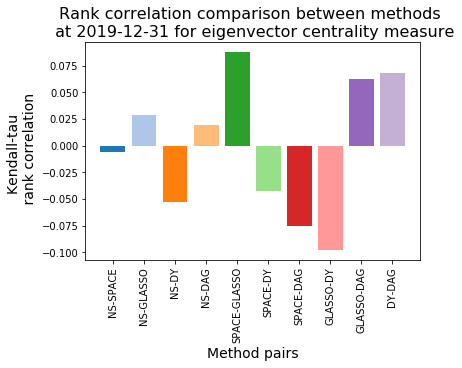

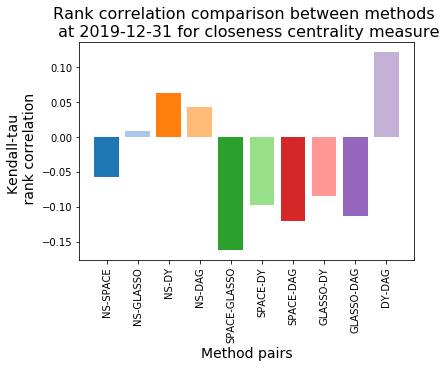

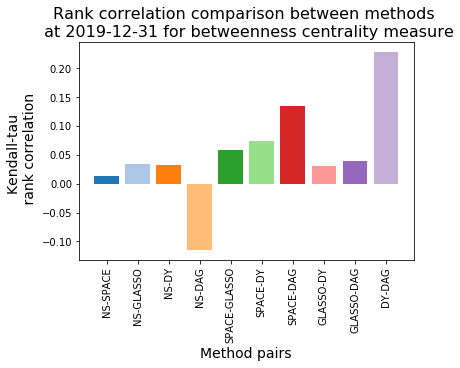

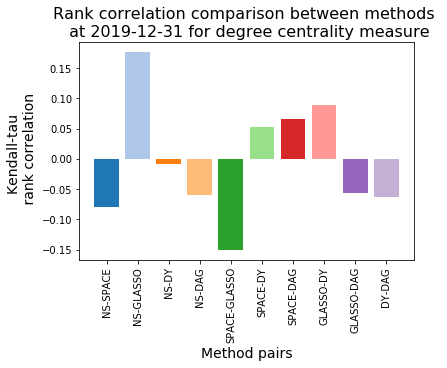

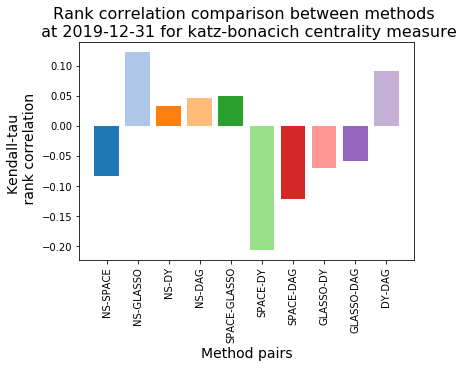

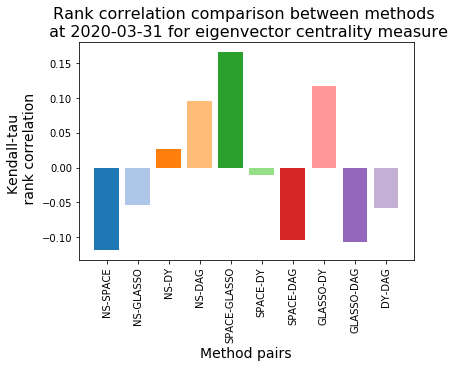

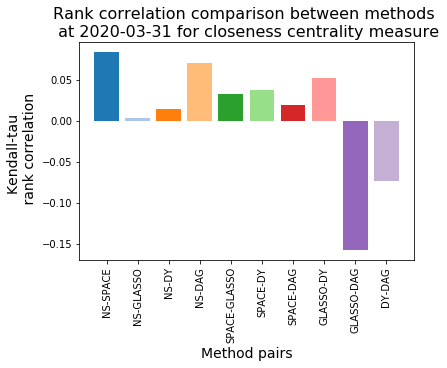

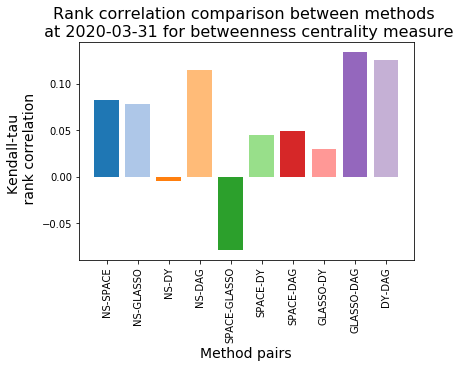

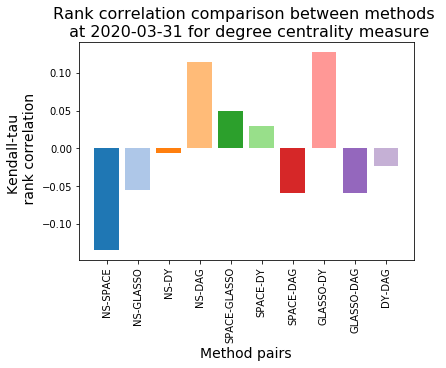

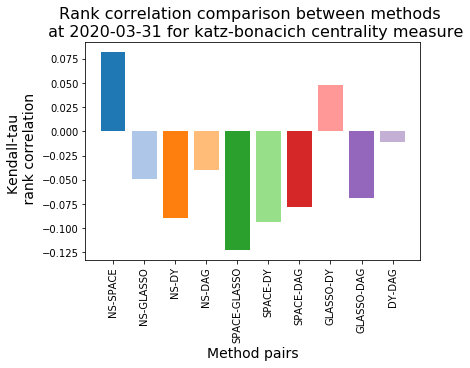

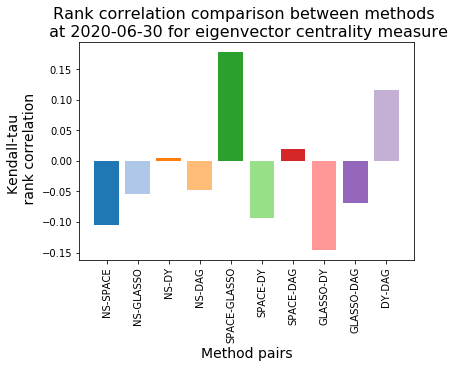

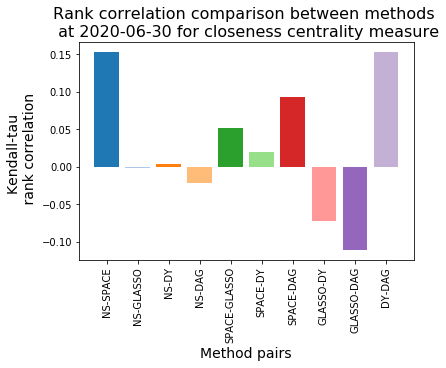

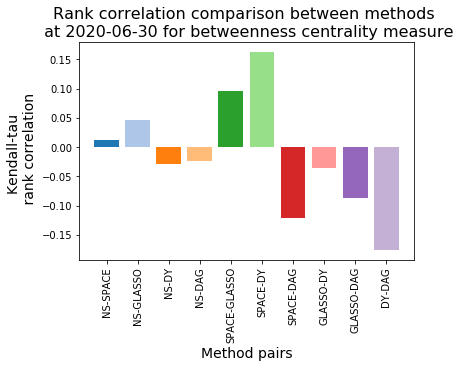

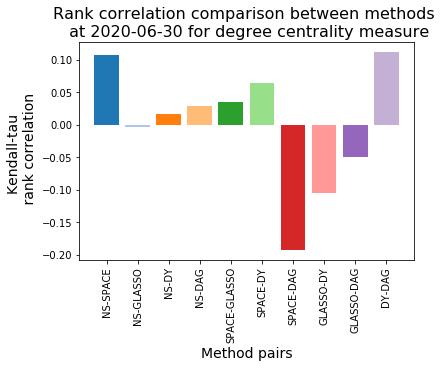

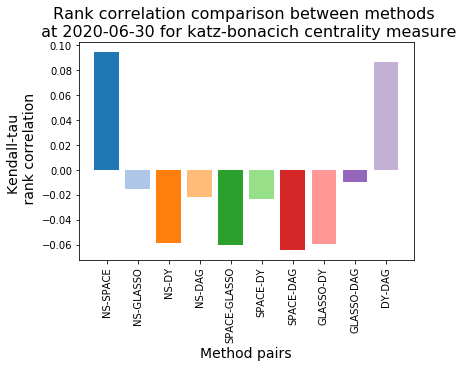

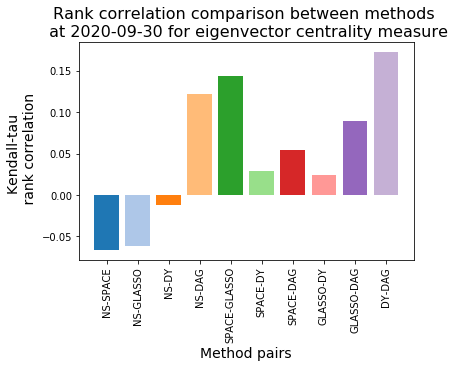

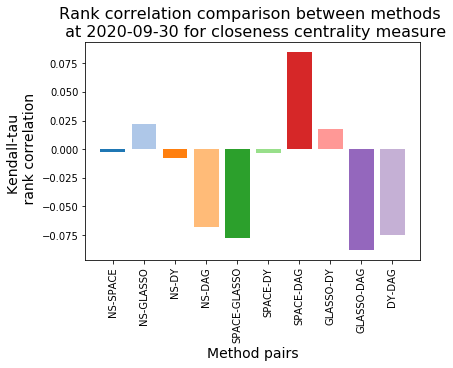

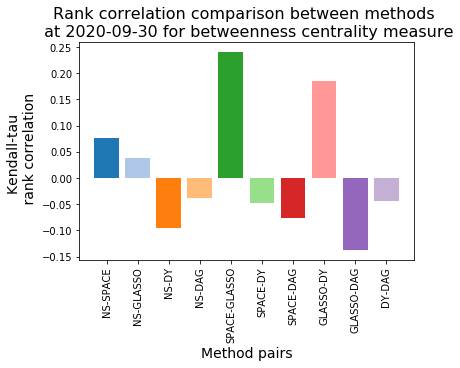

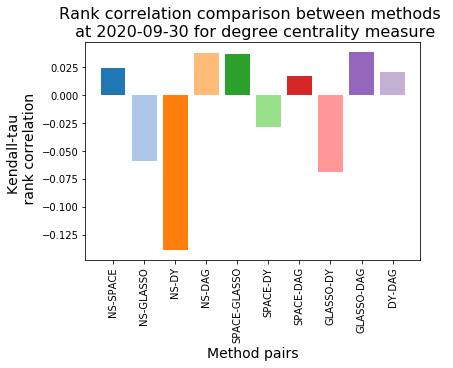

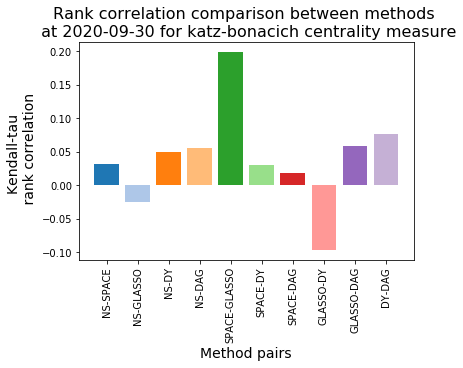

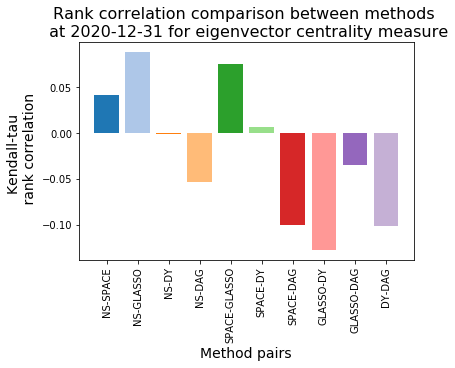

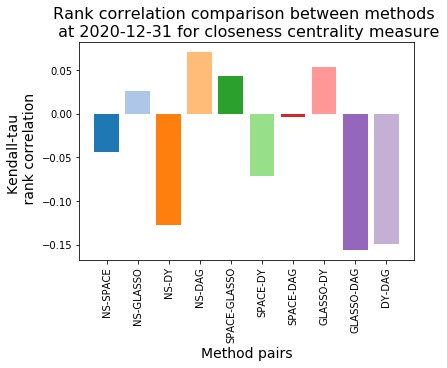

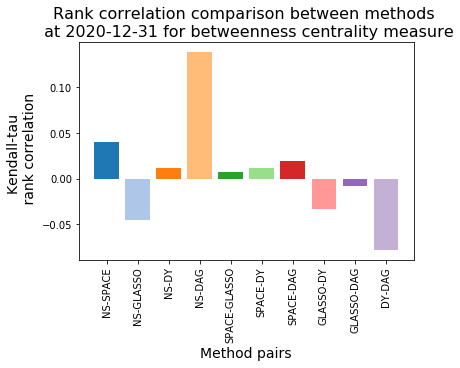

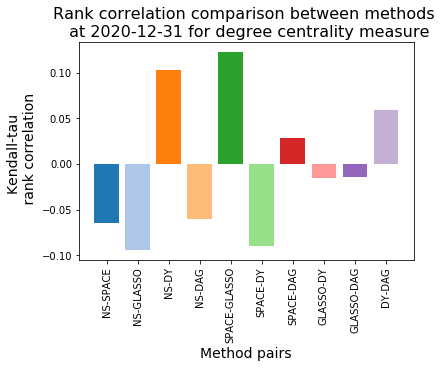

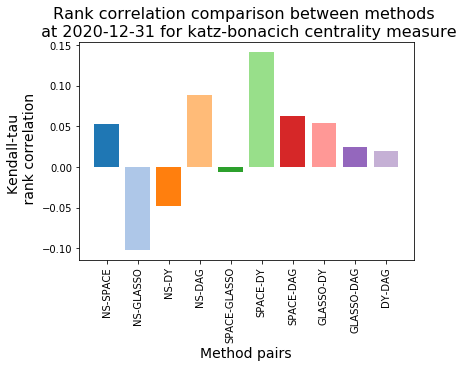

In [14]:
# Parameters
ts_type = "return"
varnames = var_names
cross_holdings = False
asset_sizes = False
ts_type = "return"
base_path = "./Data/Large_network/Estimated_networks/largenet_"
data_type = "largenet"
chosen_varnames = ["C","WFC","BAC","JPM"]
colors = colors

# Iterables
methods = ['NS','SPACE','GLASSO','DY','DAG'] #['NS','SPACE','GLASSO','DAG'] #['NS','SPACE','GLASSO','DY','DAG']
centrality_types = ["eigenvector" ,"closeness" ,"betweenness", "degree" ,"katz-bonacich"]
#dates = ["2019-12-31","2020-03-16","2020-03-31","2020-06-30","2020-09-30","2020-12-23"] #["2019-12-31","2020-03-16","2020-03-31","2020-06-30","2020-09-30","2020-12-23"]
dates = ["2019-12-31","2020-03-31","2020-06-30","2020-09-30","2020-12-31"] #["2019-12-31","2020-03-16","2020-03-31","2020-06-30","2020-09-30","2020-12-23"]


# Run rank correlation comparison function
rank_correlation_comparison(dates,methods,centrality_types,ts_type,base_path,
                            cross_holdings,asset_sizes,colors,varnames)

# Ranking visualisation

## Method 'winners'

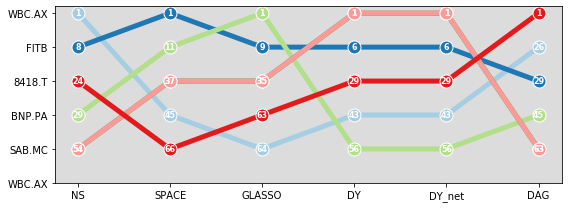

In [15]:
# Parameters
chosen_varnames = list(ranking_df.loc[0])

# Run the visualisation function
rank_viz_general(chosen_varnames,ranking_df,centrality_type,date,ts_type,data_type)

## Custom selection

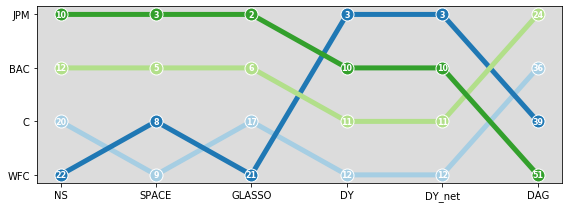

In [16]:
# Parameters
chosen_varnames = ["C","WFC","BAC","JPM"]

# Run the visualisation function
rank_viz_general(chosen_varnames,ranking_df,centrality_type,date,ts_type,data_type)

## Comparisons

Date: 2019-12-31
Centrality type: eigenvector


NS          SPACE         GLASSO        DY        DAG
0        BAC            BAC         BNP.PA   SBIN.NS    UBSG.SW
1        JPM            JPM            BAC  BBDC4.SA     DBK.DE
2          C              C            JPM    SAB.MC         RF
3       FITB           FITB         SAN.MC    8604.T     ACA.PA
4         RF             RF        INGA.AS    CBK.DE    CSGN.SW
..       ...            ...            ...       ...        ...
71    8604.T      600016.SS      600015.SS    ACA.PA  DANSKE.CO
72    EBS.VI      600015.SS      600036.SS   UBSG.SW     DNB.OL
73   SBER.ME      600036.SS        SBIN.NS    KBC.BR    SBER.ME
74  ISCTR.IS        SBIN.NS  BANKBARODA.NS    D05.SI   ISCTR.IS
75    SBK.JO  BANKBARODA.NS       ISCTR.IS   SBER.ME     SBK.JO

[76 rows x 5 columns]

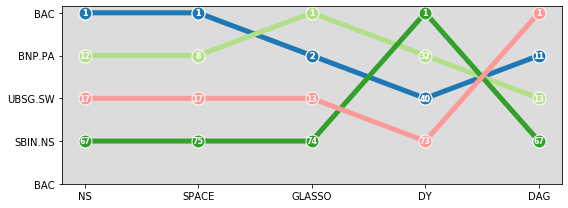

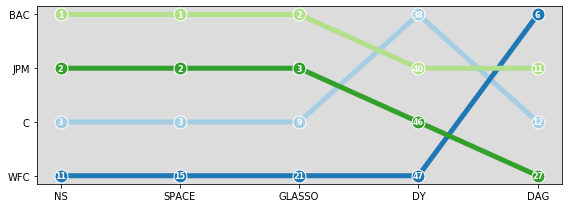

Date: 2019-12-31
Centrality type: closeness


NS          SPACE         GLASSO         DY        DAG
0       FITB         BMO.TO        CSGN.SW     BARC.L     DBK.DE
1        COF         BNP.PA       SHB-A.ST  600036.SS    UBSG.SW
2      RY.TO          MB.MI         KBC.BR        BAC     CBK.DE
3         GS         ACA.PA           FITB     LLOY.L        WFC
4     SAB.MC         8306.T         BNS.TO     8309.T     KBC.BR
..       ...            ...            ...        ...        ...
71    8604.T         UNI.MI         8331.T     ACA.PA  DANSKE.CO
72    EBS.VI         LLOY.L         CBA.AX    UBSG.SW     DNB.OL
73   SBER.ME      600016.SS        SBIN.NS     KBC.BR    SBER.ME
74  ISCTR.IS        SBIN.NS  BANKBARODA.NS     D05.SI   ISCTR.IS
75    SBK.JO  BANKBARODA.NS       ISCTR.IS    SBER.ME     SBK.JO

[76 rows x 5 columns]

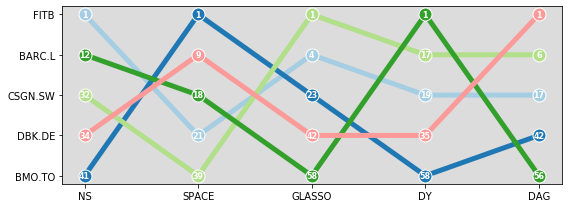

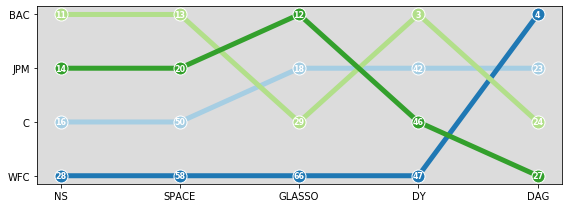

Date: 2019-12-31
Centrality type: betweenness


NS          SPACE         GLASSO         DY       DAG
0          SAB.MC         BNP.PA        CSGN.SW   ITUB4.SA    BNP.PA
1       DANSKE.CO        UBSG.SW       SHB-A.ST     WBC.AX       BAC
2       SWED-A.ST          MB.MI         KBC.BR         BK   BBVA.MC
3          CBK.DE      DANSKE.CO         BNP.PA     BNP.PA   CSGN.SW
4          DNB.OL         BMO.TO           FITB  600036.SS    CBK.DE
..            ...            ...            ...        ...       ...
71  BANKBARODA.NS         KBC.BR         CBK.DE    INGA.AS   INGA.AS
72         EBS.VI       ITUB4.SA        SBIN.NS     DNB.OL    DNB.OL
73        SBER.ME        SBIN.NS  BANKBARODA.NS    SBER.ME   SBER.ME
74       ISCTR.IS  BANKBARODA.NS        SBER.ME   ISCTR.IS  ISCTR.IS
75         SBK.JO         U11.SI       ISCTR.IS     SBK.JO    SBK.JO

[76 rows x 5 columns]

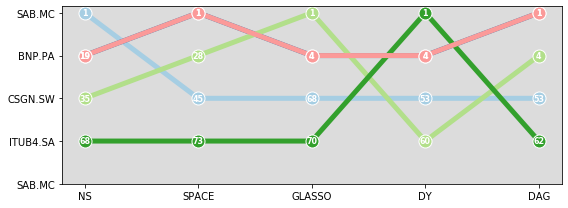

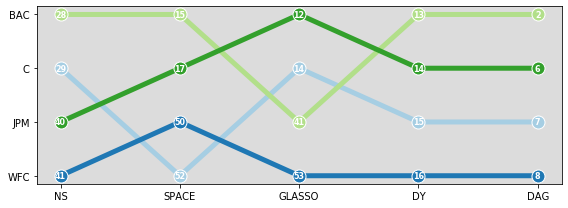

Date: 2019-12-31
Centrality type: degree


NS          SPACE         GLASSO         DY        DAG
0        BAC            BAC        UBSG.SW        BAC        JPM
1         MS         BNP.PA        CSGN.SW         BK     BNP.PA
2       FITB        UBSG.SW         BNP.PA        COF        BAC
3     BNP.PA        INGA.AS        INGA.AS        STT     8306.T
4        JPM            JPM         ACA.PA       FITB     SAN.MC
..       ...            ...            ...        ...        ...
71    8604.T         UNI.MI         CBA.AX     BMO.TO  DANSKE.CO
72    EBS.VI      600016.SS        SBER.ME      CM.TO     DNB.OL
73   SBER.ME         LLOY.L        SBIN.NS      NA.TO    SBER.ME
74  ISCTR.IS        SBIN.NS  BANKBARODA.NS  600016.SS   ISCTR.IS
75    SBK.JO  BANKBARODA.NS       ISCTR.IS    SBER.ME     SBK.JO

[76 rows x 5 columns]

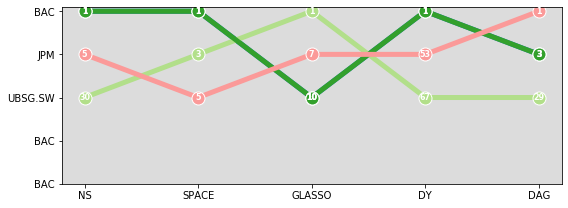

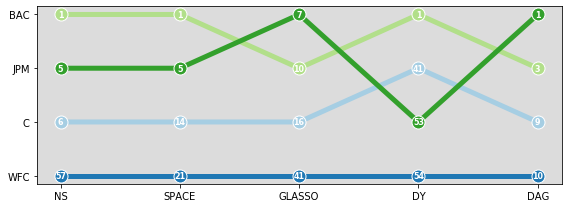

Date: 2019-12-31
Centrality type: katz-bonacich


NS     SPACE         GLASSO       DY        DAG
0        BAC    8306.T         BNP.PA      STT     ACA.PA
1     BNP.PA    BNP.PA        UBSG.SW   CBK.DE    UBSG.SW
2     8306.T       BAC         ACA.PA   SAB.MC         RF
3     ANZ.AX    ISP.MI         8306.T  SBIN.NS    CSGN.SW
4     ISP.MI    SAN.MC        INGA.AS      COF     KBC.BR
..       ...       ...            ...      ...        ...
71    8604.T    UNI.MI        SBIN.NS   ACA.PA  DANSKE.CO
72    EBS.VI    8604.T  BANKBARODA.NS  UBSG.SW     DNB.OL
73   SBER.ME   SBER.ME         SBK.JO   KBC.BR    SBER.ME
74  ISCTR.IS    SBK.JO        SBER.ME   D05.SI   ISCTR.IS
75    SBK.JO  ISCTR.IS       ISCTR.IS  SBER.ME     SBK.JO

[76 rows x 5 columns]

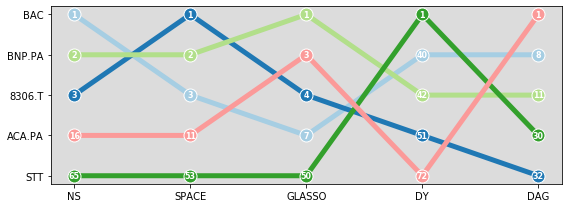

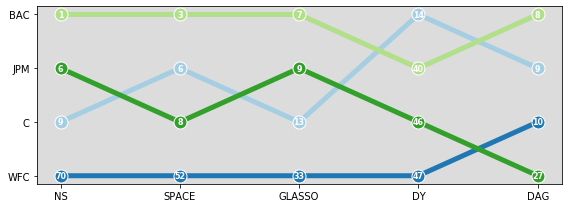

Date: 2020-03-31
Centrality type: eigenvector


NS      SPACE     GLASSO         DY        DAG
0          WBC.AX     BMO.TO          C      MB.MI    CSGN.SW
1          ANZ.AX     BNS.TO     BMO.TO     8604.T     DBK.DE
2          NAB.AX       FITB        JPM     KBC.BR     LLOY.L
3          CBA.AX          C        BAC     EBS.VI      MB.MI
4          MQG.AX        PNC     BNS.TO      CM.TO     SAN.MC
..            ...        ...        ...        ...        ...
71         SAB.MC  024110.KS   ISCTR.IS  055550.KS  DANSKE.CO
72        SBIN.NS  055550.KS  600015.SS    UBSG.SW     DNB.OL
73  BANKBARODA.NS  600000.SS  055550.KS     D05.SI    SBER.ME
74         UNI.MI  600016.SS  600000.SS     U11.SI   ISCTR.IS
75        SBER.ME  600015.SS  600016.SS   ISCTR.IS     SBK.JO

[76 rows x 5 columns]

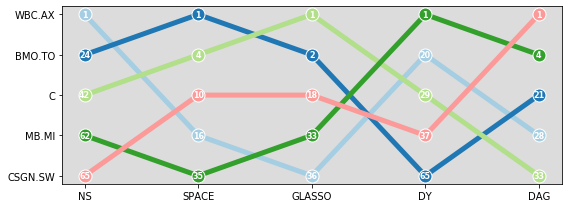

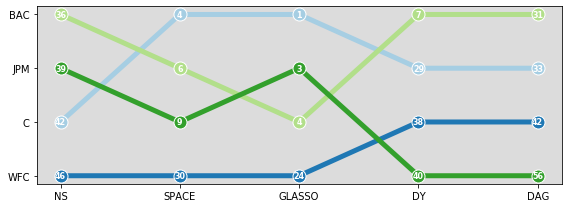

Date: 2020-03-31
Centrality type: closeness


NS      SPACE     GLASSO         DY        DAG
0       SWED-A.ST     ANZ.AX    UBSG.SW        STT     LLOY.L
1          ISP.MI  600036.SS     ACA.PA     8316.T     8418.T
2             WFC    UBSG.SW  SWED-A.ST     BNS.TO     DBK.DE
3              GS     BARC.L     D05.SI     BARC.L     EBS.VI
4           RY.TO   SHB-A.ST         MS      TD.TO     BARC.L
..            ...        ...        ...        ...        ...
71         CBA.AX        COF       FITB  055550.KS  DANSKE.CO
72       ITUB4.SA     ACA.PA     8377.T    UBSG.SW     DNB.OL
73  BANKBARODA.NS       FITB    INGA.AS     D05.SI    SBER.ME
74         WBC.AX         BK  600016.SS     U11.SI   ISCTR.IS
75      600015.SS  600016.SS     8309.T   ISCTR.IS     SBK.JO

[76 rows x 5 columns]

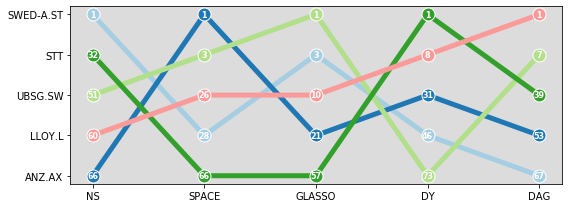

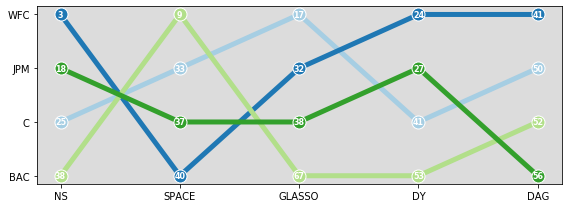

Date: 2020-03-31
Centrality type: betweenness


NS      SPACE     GLASSO        DY        DAG
0       SWED-A.ST     ANZ.AX    UBSG.SW    8331.T     UCG.MI
1          ISP.MI    UBSG.SW     ACA.PA    8316.T     BNP.PA
2             WFC        BAC         MS    BNS.TO     ISP.MI
3          STAN.L     SBK.JO     D05.SI       STT       FITB
4              GS  600036.SS     ISP.MI    8377.T    BBVA.MC
..            ...        ...        ...       ...        ...
71        CSGN.SW   BBDC4.SA     MQG.AX   INGA.AS  DANSKE.CO
72       ITUB4.SA     CBK.DE  600016.SS    DNB.OL     DNB.OL
73  BANKBARODA.NS     EBS.VI     SAN.MC   SBER.ME    SBER.ME
74         EBS.VI  DANSKE.CO  024110.KS  ISCTR.IS   ISCTR.IS
75       ISCTR.IS     DNB.OL    INGA.AS    SBK.JO     SBK.JO

[76 rows x 5 columns]

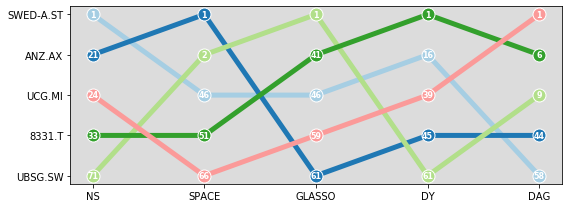

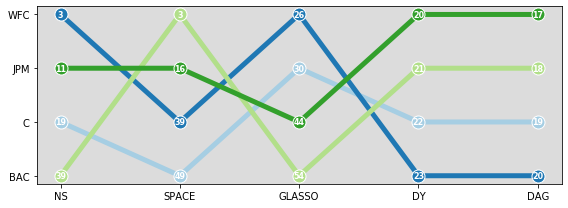

Date: 2020-03-31
Centrality type: degree


NS      SPACE     GLASSO         DY        DAG
0          ISP.MI    BBVA.MC     ACA.PA        JPM        JPM
1         INGA.AS        BAC    UBSG.SW        BAC     UCG.MI
2             JPM     BMO.TO   SEB-A.ST          C      TD.TO
3             BAC     ISP.MI      NA.TO        WFC     ISP.MI
4              GS    UBSG.SW     BARC.L         GS     8306.T
..            ...        ...        ...        ...        ...
71         CBA.AX         RF    SBIN.NS     D05.SI  DANSKE.CO
72         HSBA.L  600016.SS     8377.T     U11.SI     DNB.OL
73       ITUB4.SA  024110.KS  055550.KS   ISCTR.IS    SBER.ME
74  BANKBARODA.NS     EBS.VI  024110.KS  600016.SS   ISCTR.IS
75       ISCTR.IS   ITUB4.SA  600016.SS  600015.SS     SBK.JO

[76 rows x 5 columns]

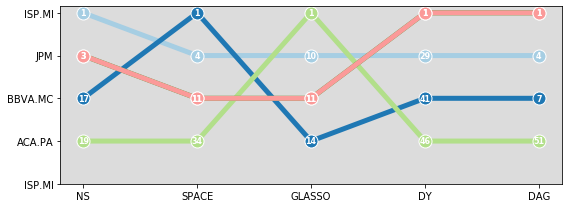

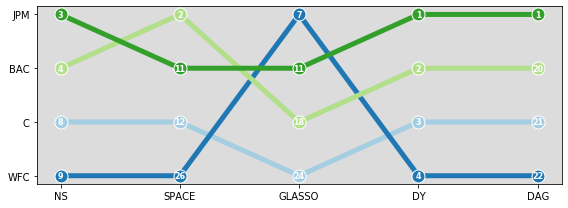

Date: 2020-03-31
Centrality type: katz-bonacich


NS     SPACE     GLASSO         DY        DAG
0     8306.T    ISP.MI    CSGN.SW      MB.MI    CSGN.SW
1     ISP.MI    BMO.TO     BMO.TO     8604.T     BNS.TO
2     ANZ.AX    8306.T     ISP.MI     KBC.BR     BMO.TO
3       FITB   CSGN.SW    UBSG.SW      CM.TO   ITUB4.SA
4    BBVA.MC   BBVA.MC    BBVA.MC     EBS.VI      CM.TO
..       ...       ...        ...        ...        ...
71    DNB.OL    UNI.MI     8604.T  055550.KS  DANSKE.CO
72   SBER.ME    DNB.OL  055550.KS    UBSG.SW     DNB.OL
73    8604.T    8604.T     HSBA.L     D05.SI    SBER.ME
74  SEB-A.ST   SBER.ME    SBER.ME     U11.SI   ISCTR.IS
75  ISCTR.IS  ISCTR.IS   ISCTR.IS   ISCTR.IS     SBK.JO

[76 rows x 5 columns]

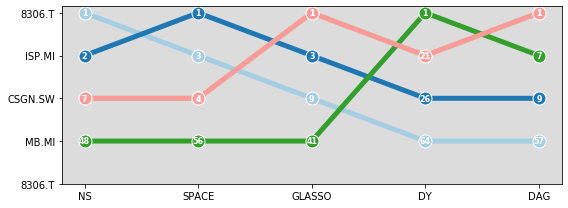

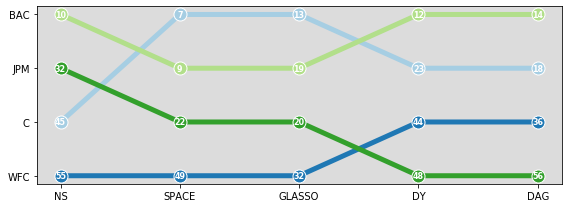

Date: 2020-06-30
Centrality type: eigenvector


NS      SPACE     GLASSO         DY        DAG
0          WBC.AX       FITB        BAC      MB.MI     DBK.DE
1          ANZ.AX        BAC          C     SAB.MC     EBS.VI
2          NAB.AX          C        JPM    INGA.AS    UBSG.SW
3          CBA.AX     ANZ.AX     BNS.TO     UCG.MI   SHB-A.ST
4            FITB     BNS.TO      TD.TO     ISP.MI     CBK.DE
..            ...        ...        ...        ...        ...
71         MQG.AX     8355.T  024110.KS  DANSKE.CO  DANSKE.CO
72  BANKBARODA.NS  600000.SS  055550.KS     DNB.OL     DNB.OL
73        SBER.ME     8604.T  600000.SS    SBER.ME    SBER.ME
74       ISCTR.IS     8418.T  600015.SS   ISCTR.IS   ISCTR.IS
75         SBK.JO     8377.T  600016.SS     SBK.JO     SBK.JO

[76 rows x 5 columns]

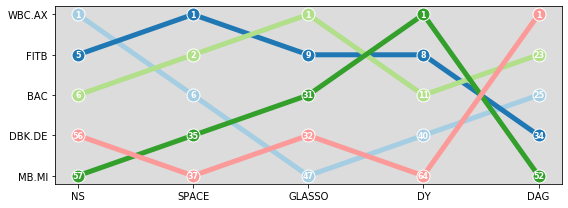

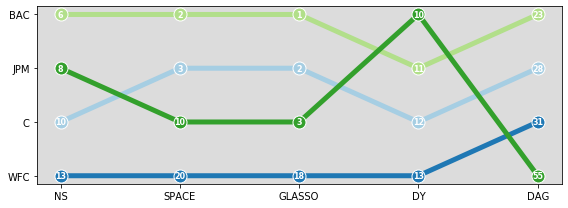

Date: 2020-06-30
Centrality type: closeness


NS      SPACE     GLASSO         DY        DAG
0      CBK.DE  600000.SS     SAB.MC     UCG.MI     DBK.DE
1     BIRG.IR     BMO.TO     BMO.TO     ISP.MI   SHB-A.ST
2      ACA.PA     BARC.L     DBK.DE      MB.MI     CBK.DE
3     INGA.AS     UCG.MI        AXP     SAB.MC    UBSG.SW
4      DBK.DE        BAC      MB.MI       FITB     EBS.VI
..        ...        ...        ...        ...        ...
71     NAB.AX     8309.T     8309.T  DANSKE.CO  DANSKE.CO
72     ANZ.AX     8316.T     8331.T     DNB.OL     DNB.OL
73     CBA.AX     UNI.MI  055550.KS    SBER.ME    SBER.ME
74     WBC.AX     CBA.AX     8377.T   ISCTR.IS   ISCTR.IS
75  055550.KS  600016.SS     8418.T     SBK.JO     SBK.JO

[76 rows x 5 columns]

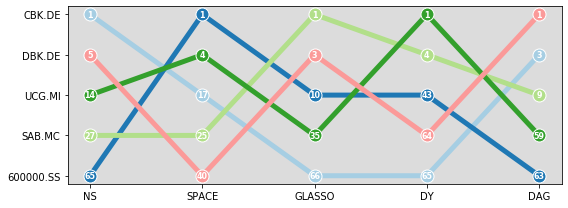

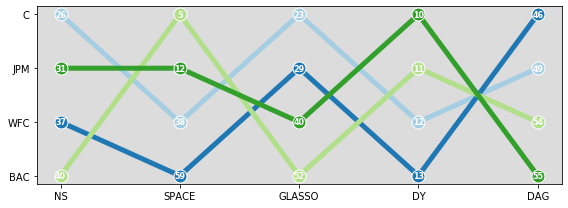

Date: 2020-06-30
Centrality type: betweenness


NS          SPACE     GLASSO        DY        DAG
0          CBK.DE      600000.SS     SAB.MC    SAB.MC    BBVA.MC
1         INGA.AS         BMO.TO     BMO.TO       JPM     BARC.L
2          ACA.PA            AXP     LLOY.L       BAC     SAN.MC
3             AXP            BAC     BNP.PA         C     ACA.PA
4       DANSKE.CO         BARC.L        AXP       WFC    CSGN.SW
..            ...            ...        ...       ...        ...
71  BANKBARODA.NS        SBIN.NS     CBK.DE   INGA.AS  DANSKE.CO
72         D05.SI  BANKBARODA.NS    SBIN.NS    DNB.OL     DNB.OL
73         EBS.VI         U11.SI     D05.SI   SBER.ME    SBER.ME
74       ISCTR.IS         EBS.VI  DANSKE.CO  ISCTR.IS   ISCTR.IS
75         SBK.JO      DANSKE.CO    INGA.AS    SBK.JO     SBK.JO

[76 rows x 5 columns]

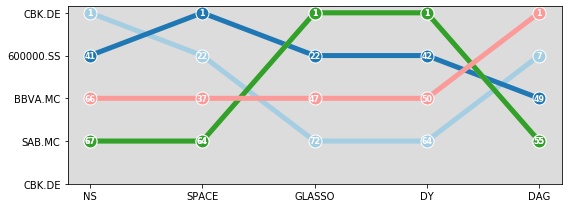

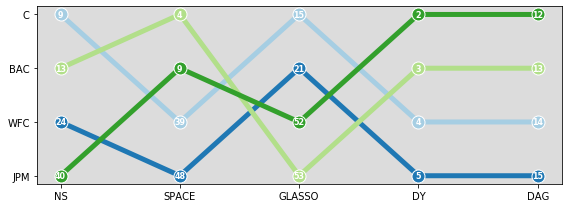

Date: 2020-06-30
Centrality type: degree


NS          SPACE     GLASSO         DY        DAG
0          ACA.PA            BAC     BNP.PA      MB.MI        JPM
1         INGA.AS         BMO.TO     ACA.PA     UCG.MI      TD.TO
2             BAC       SEB-A.ST     BARC.L     SAB.MC     8306.T
3               C         ACA.PA    CSGN.SW     ISP.MI     NAB.AX
4             AXP        CSGN.SW      NA.TO       FITB     SAN.MC
..            ...            ...        ...        ...        ...
71       ITUB4.SA      055550.KS     8418.T  DANSKE.CO  DANSKE.CO
72  BANKBARODA.NS      024110.KS  600015.SS     DNB.OL     DNB.OL
73         D05.SI       BBDC4.SA  024110.KS    SBER.ME    SBER.ME
74       ISCTR.IS  BANKBARODA.NS  055550.KS   ISCTR.IS   ISCTR.IS
75         SBK.JO       ITUB4.SA  600016.SS     SBK.JO     SBK.JO

[76 rows x 5 columns]

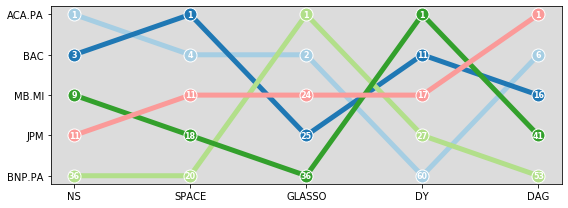

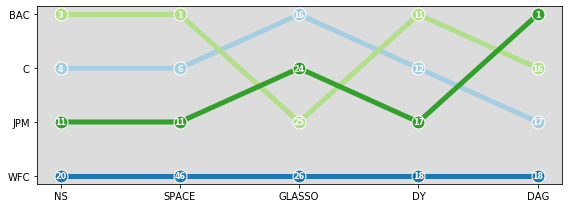

Date: 2020-06-30
Centrality type: katz-bonacich


NS     SPACE         GLASSO         DY        DAG
0    CSGN.SW   CSGN.SW        CSGN.SW      MB.MI     BNS.TO
1     ACA.PA    8306.T         ACA.PA     SAB.MC      RY.TO
2       FITB    ANZ.AX        BBVA.MC    INGA.AS      CM.TO
3        BAC    ACA.PA         BMO.TO     ISP.MI     SAN.MC
4     8306.T    BNS.TO         CBK.DE         RF     BMO.TO
..       ...       ...            ...        ...        ...
71   SBER.ME    8604.T         UNI.MI  DANSKE.CO  DANSKE.CO
72    MQG.AX    CBA.AX       ITUB4.SA     DNB.OL     DNB.OL
73  ISCTR.IS    SBK.JO  BANKBARODA.NS    SBER.ME    SBER.ME
74    SBK.JO  ISCTR.IS       ISCTR.IS   ISCTR.IS   ISCTR.IS
75    8604.T   SBER.ME        SBER.ME     SBK.JO     SBK.JO

[76 rows x 5 columns]

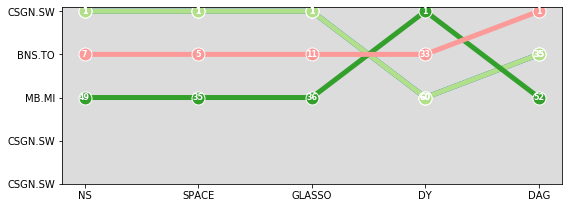

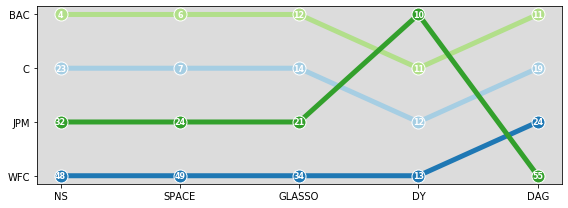

Date: 2020-09-30
Centrality type: eigenvector


NS          SPACE     GLASSO         DY       DAG
0     WBC.AX         WBC.AX        BAC      MB.MI       PNC
1     ANZ.AX         ANZ.AX        JPM    INGA.AS      FITB
2     NAB.AX           FITB          C     ISP.MI  BBDC4.SA
3     CBA.AX            BAC      TD.TO     SAB.MC       STT
4       FITB         NAB.AX     BNS.TO         RF    CBK.DE
..       ...            ...        ...        ...       ...
71    D05.SI         8418.T  055550.KS  DANSKE.CO    BNS.TO
72    8604.T        SBER.ME  600036.SS     DNB.OL     RY.TO
73    MQG.AX         8604.T  600000.SS    SBER.ME       COF
74  ISCTR.IS         8377.T  600016.SS   ISCTR.IS     TD.TO
75    SBK.JO  BANKBARODA.NS  600015.SS     SBK.JO       JPM

[76 rows x 5 columns]

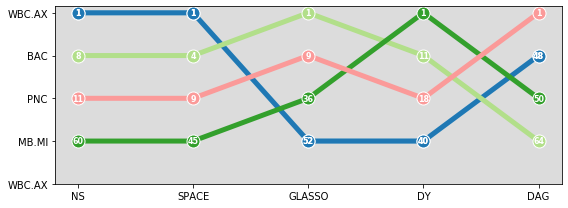

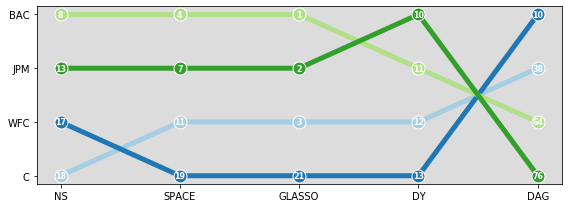

Date: 2020-09-30
Centrality type: closeness


NS      SPACE     GLASSO         DY     DAG
0      8331.T     8604.T     CBK.DE      CM.TO  EBS.VI
1      8308.T        AXP     DNB.OL     SAB.MC  8316.T
2     CSGN.SW   SEB-A.ST   SEB-A.ST      MB.MI     PNC
3      LLOY.L     ISP.MI     STAN.L     UCG.MI      BK
4      ACA.PA      TD.TO    BBVA.MC     ISP.MI   NA.TO
..        ...        ...        ...        ...     ...
71  024110.KS         BK      TD.TO  DANSKE.CO   RY.TO
72     8604.T     8316.T      MB.MI     DNB.OL  BNS.TO
73     MQG.AX        USB     8418.T    SBER.ME   TD.TO
74   ISCTR.IS  600016.SS  600015.SS   ISCTR.IS     COF
75     SBK.JO   ITUB4.SA  600016.SS     SBK.JO     JPM

[76 rows x 5 columns]

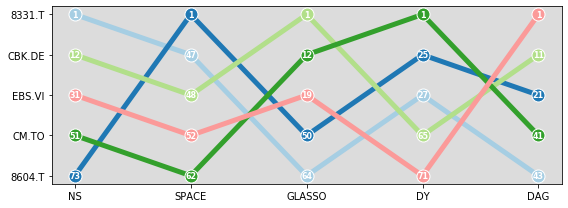

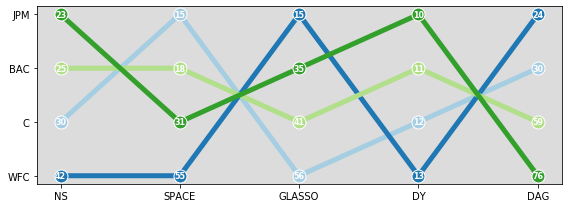

Date: 2020-09-30
Centrality type: betweenness


NS          SPACE     GLASSO        DY        DAG
0         GS         8604.T     DNB.OL       JPM     MQG.AX
1    CSGN.SW          TD.TO     CBK.DE       BAC     8308.T
2        AXP            AXP    BBVA.MC         C    INGA.AS
3      RY.TO       SEB-A.ST   SEB-A.ST       WFC  600000.SS
4        JPM         ISP.MI  SWED-A.ST        GS     KBC.BR
..       ...            ...        ...       ...        ...
71    EBS.VI        CSGN.SW     SAB.MC   INGA.AS     8604.T
72    DNB.OL         KBC.BR  055550.KS    DNB.OL      NA.TO
73   SBER.ME       ITUB4.SA    SBIN.NS   SBER.ME      MB.MI
74  ISCTR.IS  BANKBARODA.NS  DANSKE.CO  ISCTR.IS     STAN.L
75    SBK.JO        SBER.ME    SBER.ME    SBK.JO     EBS.VI

[76 rows x 5 columns]

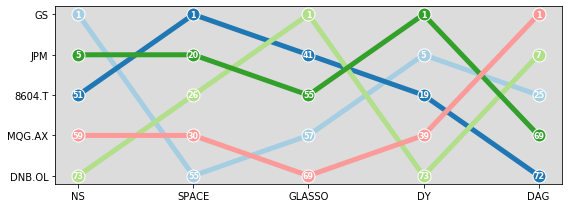

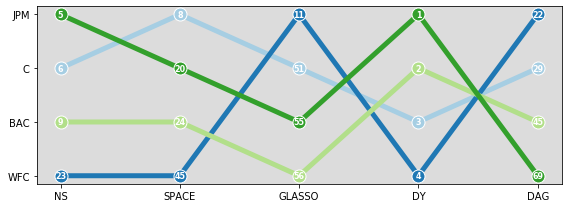

Date: 2020-09-30
Centrality type: degree


NS          SPACE     GLASSO         DY            DAG
0     ACA.PA       SEB-A.ST     BNP.PA      MB.MI            JPM
1        BAC         BARC.L     ACA.PA     SAB.MC         UCG.MI
2    CSGN.SW        INGA.AS    CSGN.SW     ISP.MI         UNI.MI
3         MS          TD.TO     BARC.L  055550.KS         8306.T
4          C            AXP      CM.TO        STT         8377.T
..       ...            ...        ...        ...            ...
71   SBER.ME      600015.SS    SBER.ME  DANSKE.CO        UBSG.SW
72    8604.T      055550.KS     8418.T     DNB.OL  BANKBARODA.NS
73    MQG.AX       BBDC4.SA  055550.KS    SBER.ME            BAC
74  ISCTR.IS  BANKBARODA.NS  600016.SS   ISCTR.IS         8418.T
75    SBK.JO       ITUB4.SA  600015.SS     SBK.JO         SAB.MC

[76 rows x 5 columns]

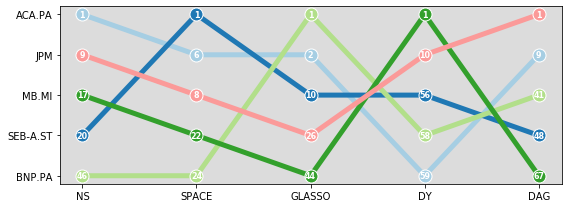

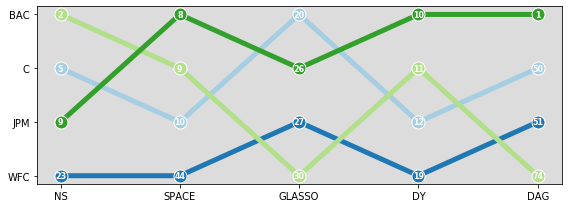

Date: 2020-09-30
Centrality type: katz-bonacich


NS     SPACE         GLASSO         DY       DAG
0      ACA.PA    8306.T         ACA.PA      MB.MI    EBS.VI
1        FITB   CSGN.SW        CSGN.SW     ISP.MI    8411.T
2         BAC    ANZ.AX         BMO.TO         RF   SBIN.NS
3     CSGN.SW    ACA.PA         BNP.PA    INGA.AS    8604.T
4   600016.SS    SAN.MC         BARC.L     SAB.MC    BNP.PA
..        ...       ...            ...        ...       ...
71    SBER.ME    MQG.AX       ITUB4.SA  DANSKE.CO  ISCTR.IS
72     8604.T    8604.T         SBK.JO     DNB.OL    UCG.MI
73     MQG.AX    SBK.JO  BANKBARODA.NS    SBER.ME   SBER.ME
74   ISCTR.IS   SBER.ME       ISCTR.IS   ISCTR.IS    SBK.JO
75     SBK.JO  ISCTR.IS        SBER.ME     SBK.JO       JPM

[76 rows x 5 columns]

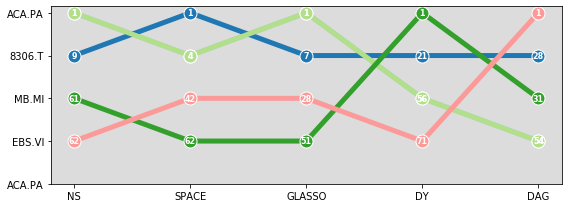

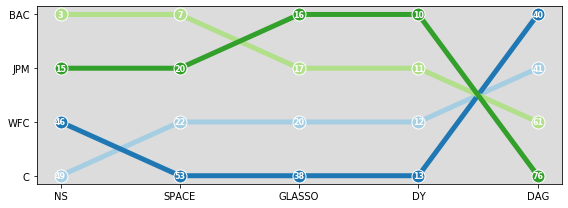

Date: 2020-12-31
Centrality type: eigenvector


NS          SPACE         GLASSO         DY        DAG
0      WBC.AX           FITB         BNP.PA     SAB.MC     8418.T
1      ANZ.AX             RF            JPM         RF     8377.T
2      NAB.AX            JPM         ACA.PA        WFC    BBVA.MC
3      CBA.AX            USB         SAN.MC    BIRG.IR     EBS.VI
4      8316.T            BAC            USB    BBVA.MC     DBK.DE
..        ...            ...            ...        ...        ...
71  024110.KS  BANKBARODA.NS      600036.SS  DANSKE.CO  DANSKE.CO
72     MQG.AX      600000.SS  BANKBARODA.NS    INGA.AS     DNB.OL
73    SBER.ME      600016.SS      600000.SS     DNB.OL    SBER.ME
74   ISCTR.IS      600036.SS      600016.SS    SBER.ME   ISCTR.IS
75     SBK.JO      600015.SS      600015.SS   ISCTR.IS     SBK.JO

[76 rows x 5 columns]

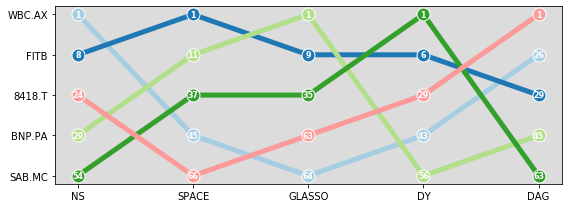

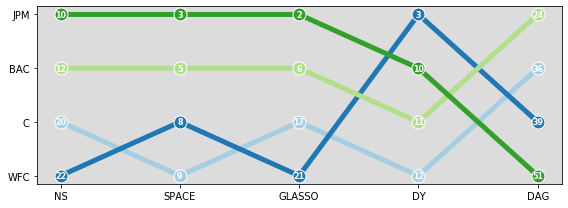

Date: 2020-12-31
Centrality type: closeness


NS          SPACE         GLASSO         DY        DAG
0     EBS.VI        INGA.AS         HSBA.L     SBK.JO     8418.T
1     KBC.BR          MB.MI         EBS.VI    BBVA.MC     8377.T
2     ISP.MI            WFC            USB     SAN.MC     8331.T
3    UBSG.SW            AXP         D05.SI    BIRG.IR     KBC.BR
4   SEB-A.ST        CSGN.SW         BMO.TO        AXP     DBK.DE
..       ...            ...            ...        ...        ...
71  BBDC4.SA         NAB.AX         8411.T  DANSKE.CO  DANSKE.CO
72    MQG.AX      600016.SS         8355.T    INGA.AS     DNB.OL
73   SBER.ME      600015.SS      600036.SS     DNB.OL    SBER.ME
74  ISCTR.IS  BANKBARODA.NS      600015.SS    SBER.ME   ISCTR.IS
75    SBK.JO       ITUB4.SA  BANKBARODA.NS   ISCTR.IS     SBK.JO

[76 rows x 5 columns]

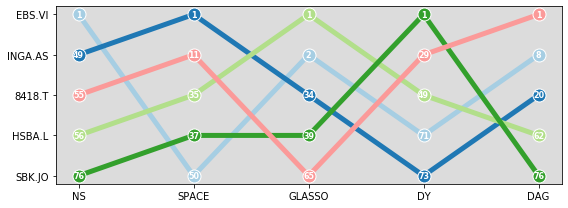

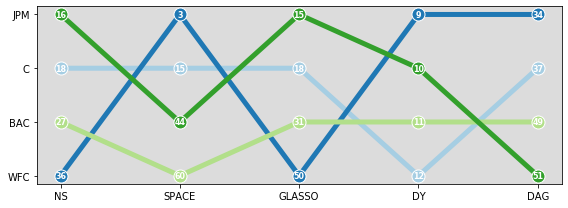

Date: 2020-12-31
Centrality type: betweenness


NS          SPACE         GLASSO         DY       DAG
0     ISP.MI        INGA.AS         HSBA.L     SBK.JO    BNP.PA
1     EBS.VI            WFC         EBS.VI        JPM    8331.T
2     KBC.BR          NA.TO         SAN.MC        BAC    8355.T
3      TD.TO          MB.MI         D05.SI          C    SAN.MC
4    UBSG.SW            COF            USB        WFC    8308.T
..       ...            ...            ...        ...       ...
71    D05.SI       ITUB4.SA        BBVA.MC  DANSKE.CO   INGA.AS
72   INGA.AS         DBK.DE         BNP.PA    INGA.AS    DNB.OL
73   SBER.ME        BIRG.IR        CSGN.SW     DNB.OL   SBER.ME
74  ISCTR.IS  BANKBARODA.NS  BANKBARODA.NS    SBER.ME  ISCTR.IS
75    SBK.JO         D05.SI       ISCTR.IS   ISCTR.IS    SBK.JO

[76 rows x 5 columns]

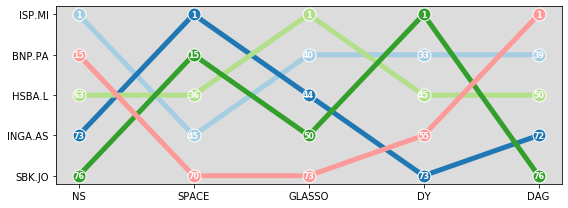

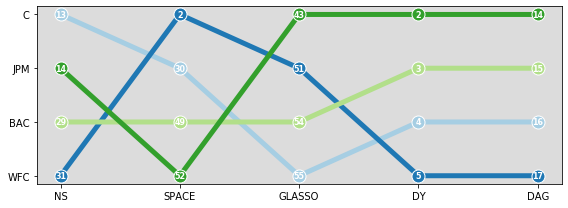

Date: 2020-12-31
Centrality type: degree


NS          SPACE         GLASSO         DY        DAG
0     ISP.MI         EBS.VI         BNP.PA     SAB.MC        JPM
1     8308.T            JPM         EBS.VI         RF     BNP.PA
2     SAN.MC         BNP.PA         KBC.BR    BIRG.IR     8306.T
3     EBS.VI        INGA.AS        INGA.AS     SBK.JO     SAN.MC
4        JPM         SAN.MC            AXP    BBVA.MC      TD.TO
..       ...            ...            ...        ...        ...
71    D05.SI      600016.SS      600036.SS     EBS.VI  DANSKE.CO
72    MQG.AX      055550.KS      600000.SS  DANSKE.CO     DNB.OL
73   SBER.ME      600015.SS      600016.SS    INGA.AS    SBER.ME
74  ISCTR.IS       ITUB4.SA      600015.SS     DNB.OL   ISCTR.IS
75    SBK.JO  BANKBARODA.NS  BANKBARODA.NS    SBER.ME     SBK.JO

[76 rows x 5 columns]

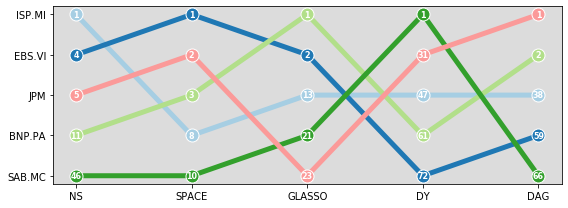

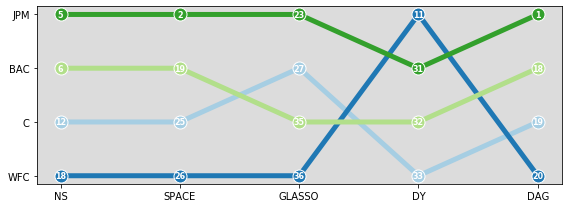

Date: 2020-12-31
Centrality type: katz-bonacich


NS      SPACE         GLASSO         DY        DAG
0      BNP.PA     BNP.PA         BNP.PA     SAB.MC     ACA.PA
1   600000.SS        JPM         ACA.PA         RF     SAN.MC
2      8316.T     ANZ.AX         ISP.MI        WFC    UBSG.SW
3         JPM     SAN.MC            JPM    BIRG.IR     LLOY.L
4        FITB  600000.SS         SAN.MC    BBVA.MC    INGA.AS
..        ...        ...            ...        ...        ...
71     8604.T     UNI.MI         MQG.AX  DANSKE.CO  DANSKE.CO
72     MQG.AX     MQG.AX        SBER.ME    INGA.AS     DNB.OL
73    SBER.ME     SBK.JO  BANKBARODA.NS     DNB.OL    SBER.ME
74   ISCTR.IS    SBER.ME         SBK.JO    SBER.ME   ISCTR.IS
75     SBK.JO   ISCTR.IS       ISCTR.IS   ISCTR.IS     SBK.JO

[76 rows x 5 columns]

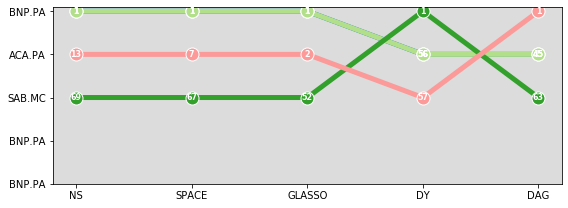

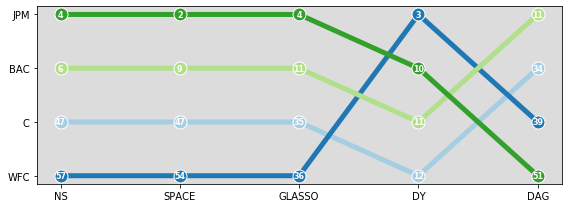

In [17]:
# Parameters
varnames = var_names
cross_holdings = False
asset_sizes = False

ts_type = "return"
base_path = "./Data/Large_network/Estimated_networks/largenet_"
data_type = "largenet"
chosen_varnames = ["C","WFC","BAC","JPM"]



# Iterables
methods = ['NS','SPACE','GLASSO','DY','DAG'] #['NS','SPACE','GLASSO','DAG'] #['NS','SPACE','GLASSO','DY','DAG']
centrality_types = ["eigenvector" ,"closeness" ,"betweenness", "degree" ,"katz-bonacich"]
#dates = ["2019-12-31","2020-03-16","2020-03-31","2020-06-30","2020-09-30","2020-12-23"] #["2019-12-31","2020-03-16","2020-03-31","2020-06-30","2020-09-30","2020-12-23"]
dates = ["2019-12-31","2020-03-31","2020-06-30","2020-09-30","2020-12-31"] #["2019-12-31","2020-03-16","2020-03-31","2020-06-30","2020-09-30","2020-12-23"]


for date in dates:
    for centrality_type in centrality_types:

        # Create dictionary to store the outputs
        networks = {}

        for method in methods:

            networks[method] = network_preprocessing_general(date,method,ts_type,base_path)



        print("Date: {}".format(date))
        print("Centrality type: {}".format(centrality_type))


        # Create centrality rankings
        if cross_holdings:
            CH_network = CH_network
        else:
            CH_network = None

        if asset_sizes:
            varnames_sorted_by_asset = varnames_sorted_by_asset
        else:
            varnames_sorted_by_asset = None

        # Create centrality rankings
        ranking_df = centrality_ranking_df(centrality_type,networks,varnames,varnames_sorted_by_asset,CH_network)

        # Inspect the dataframe
        display(ranking_df)

        # Parameters
        current_winners = list(ranking_df.loc[0])

        # Run the visualisation function
        rank_viz_general(current_winners,ranking_df,centrality_type,date,ts_type,data_type)


        # Run the visualisation function
        rank_viz_general(chosen_varnames,ranking_df,centrality_type,date,ts_type,data_type)

# Robustness/persistence checks

In [18]:
# Parameters
dates = ["2019-12-31","2020-03-16","2020-03-31","2020-06-30","2020-09-30","2020-12-23"] #["2019-12-31","2020-03-16","2020-03-31","2020-06-30","2020-09-30","2020-12-23"]
dates = ["2019-12-31","2020-03-31","2020-06-30","2020-09-30","2020-12-31"]
ts_type = "return"
base_path = "./Data/Large_network/Estimated_networks/largenet_"
data_type = "largenet"

# Iterables
methods = ['NS','SPACE','GLASSO','DY','DAG'] #['NS','SPACE','GLASSO','DY','DY_net','DAG'] #['NS','SPACE','GLASSO','DAG'] #['NS','SPACE','GLASSO','DY','DAG']

# Placeholder

In [19]:
# Check robustness results
robustness_results = {}

for method in methods:
    
    res = []
    
    for i in range(1,len(dates)):
        
        current_dates = dates[i-1:i+1]
        
        frob_norm = general_robustness_check(current_dates,method,ts_type,base_path)
        res.append(frob_norm)
        
    robustness_results[method] = res

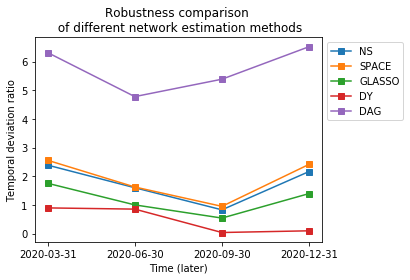

In [20]:
for key, val in robustness_results.items():
    
    plt.plot(val,marker="s",label=key)
    
plt.legend(loc = 'upper right', bbox_to_anchor=(1.3, 1))
plt.title("Robustness comparison \n of different network estimation methods")
#plt.yscale('log')
plt.xlabel("Time (later)")
plt.ylabel("Temporal deviation ratio")
plt.xticks(np.arange(len(dates)-1),dates[1:])
plt.tight_layout()
plt.savefig('./Figures/Large_network/persistence_robustness.pdf',dpi=120)
plt.show()

# Visualise network

## Single examples

In [21]:
# # This cell is to explore the plotting of edge width/color options

# def network_viz_general(date,method,ts_type,var_names, color_map,
# base_path,data_type):

#     print("Method: {}".format(method))

#     # Import network
#     G = network_preprocessing_general(date,method,ts_type,base_path)

#     label_dict = {}

#     for i in range(0,len(var_names)):
#         label_dict[i] = var_names[i]

#     # Relabel network
#     G = nx.relabel_nodes(G, label_dict)

#     # Get edge weights
#     edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())


#     # Parameters
#     plt.rcParams['figure.figsize'] = (12,12)

#     # Get degrees
#     degree_demirer = dict(G.degree)

#     # Draw network
#     nx.draw_networkx(G,
#                          #nodelist=degree_mcc_network.keys(),
#                          node_size=[v * 5 for v in degree_demirer.values()],
#                          #node_color=colors,
#                          font_size=8, node_color=color_map,
#                      edgelist=edges,
#                      edge_color=weights,
#                      width=weights, edge_cmap=plt.cm.Purples,
#                          with_labels=True)

#     plt.savefig('./Figures/{}_{}_{}_{}.pdf'.format(data_type,ts_type,method,date),dpi = 120)
#     plt.show()

Method: NS


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

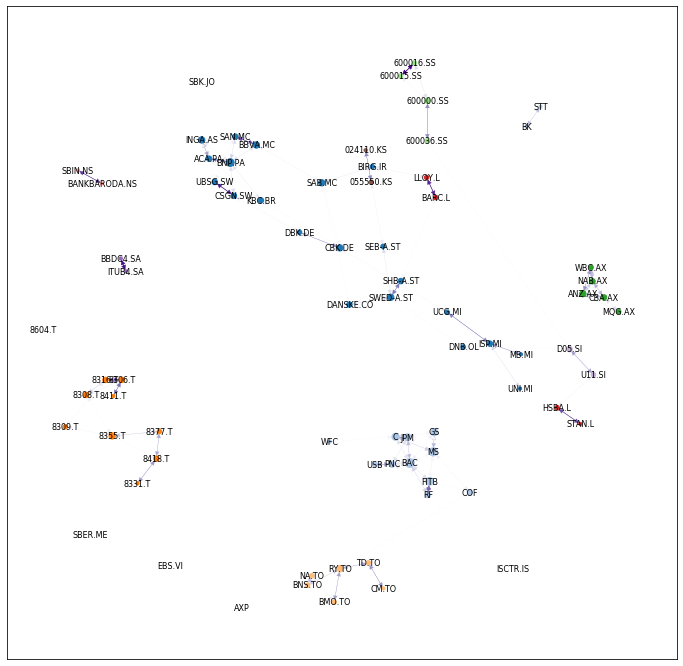

Method: SPACE


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

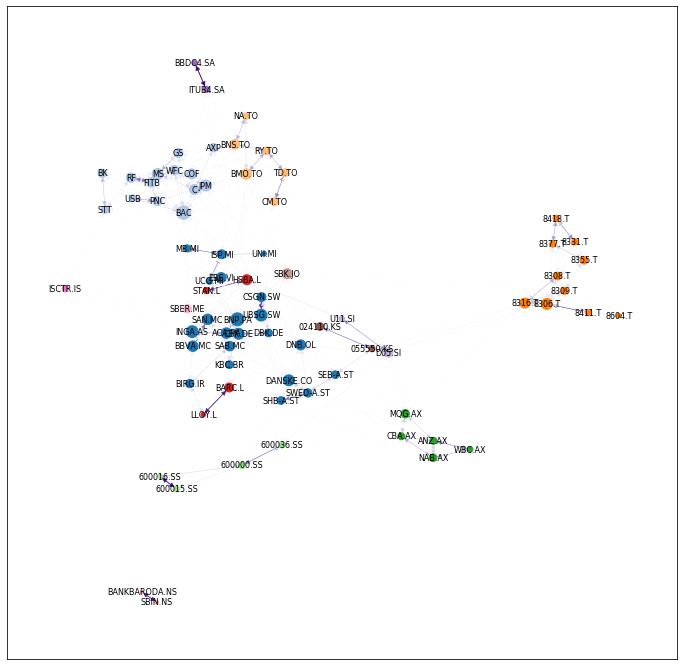

Method: GLASSO


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

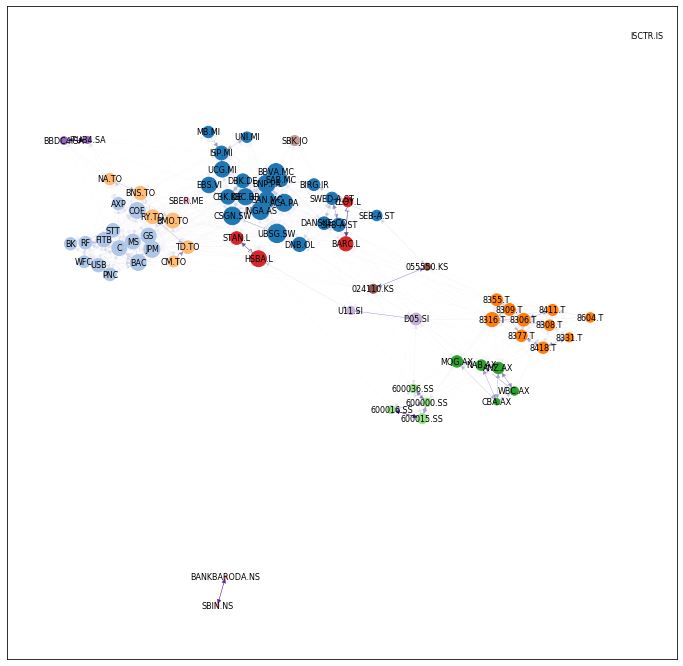

Method: DY


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

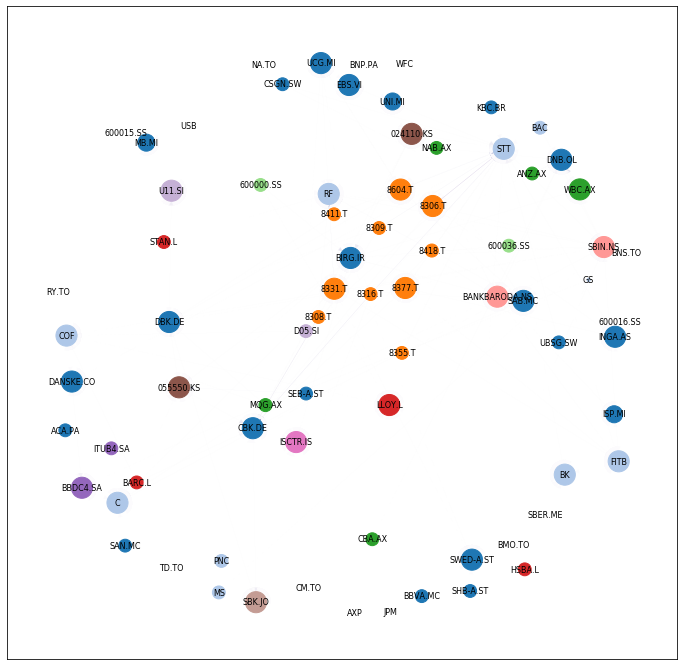

Method: DY_net


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

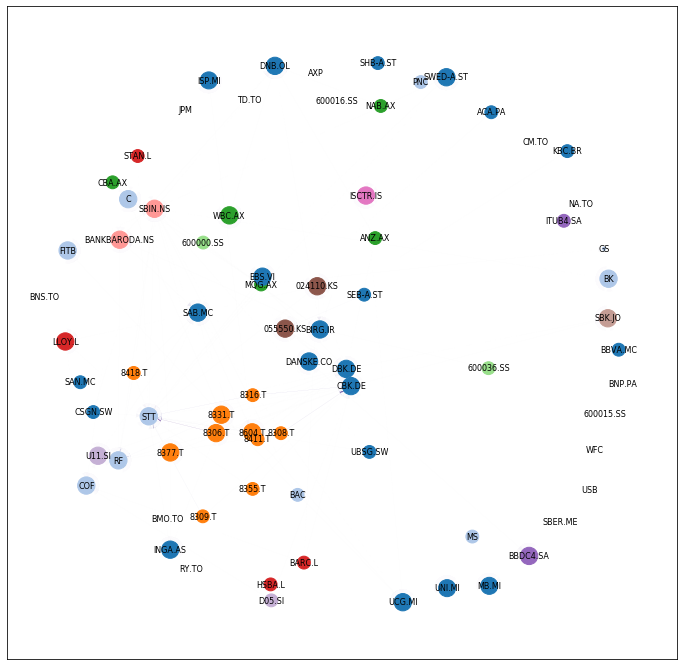

Method: DAG


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

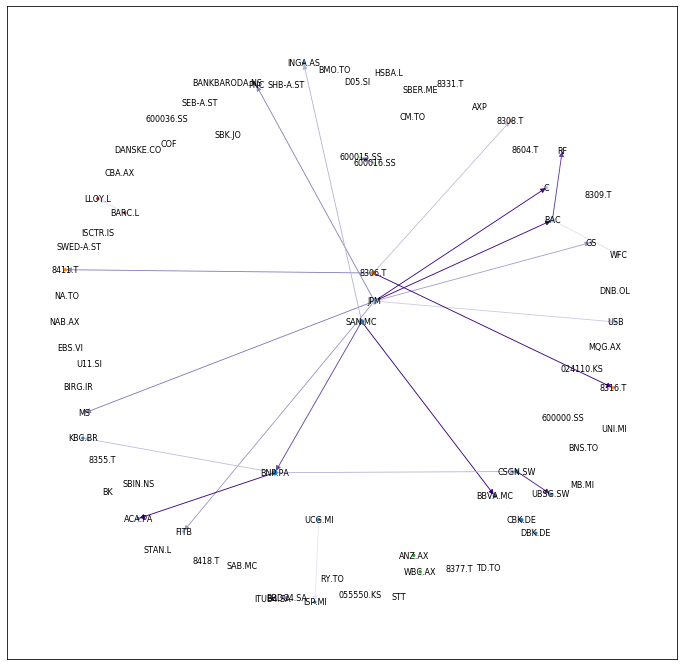

In [30]:
# Parameters
date = "2019-12-31" #"2020-06-30"
ts_type = "return"

# Iterables
methods = ['NS','SPACE','GLASSO','DY','DAG']

for method in methods:
    
    network_viz_general(date,method,ts_type,var_names,country_colors, base_path, data_type)

## Combinations

Date: 2019-12-31
Method: NS


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

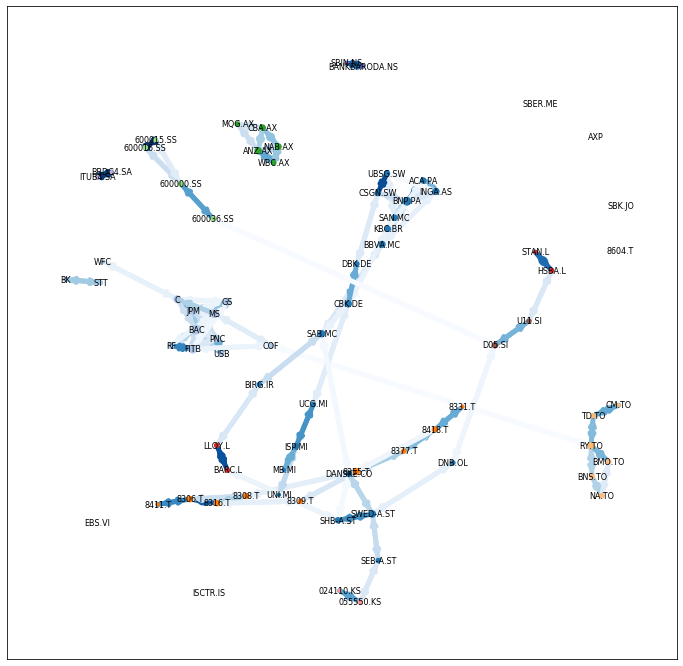

Date: 2019-12-31
Method: SPACE


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

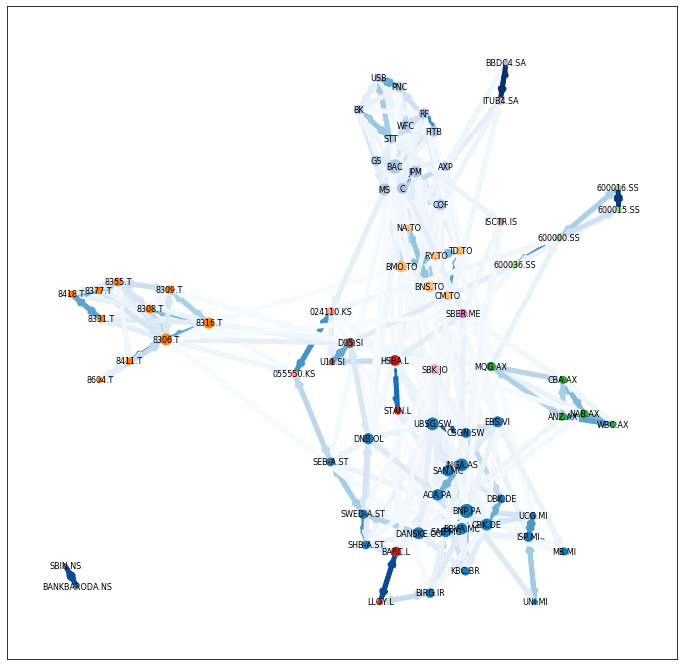

Date: 2019-12-31
Method: GLASSO


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

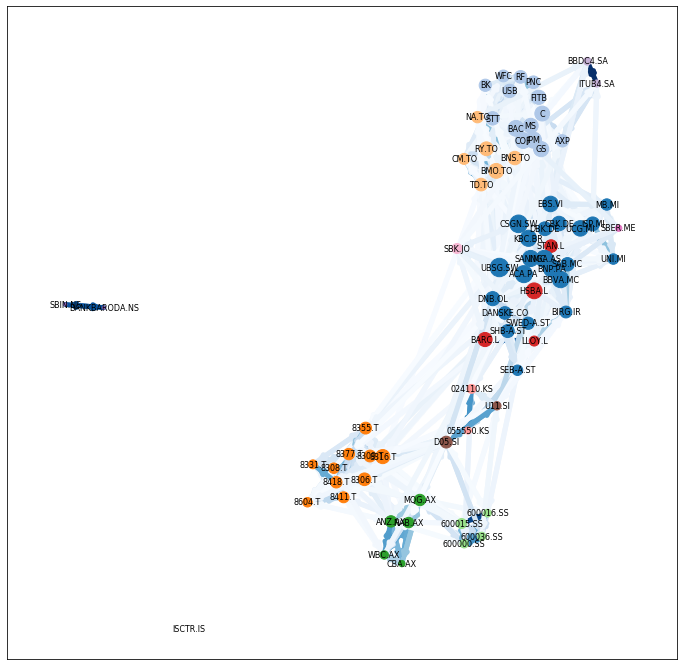

Date: 2019-12-31
Method: DY


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

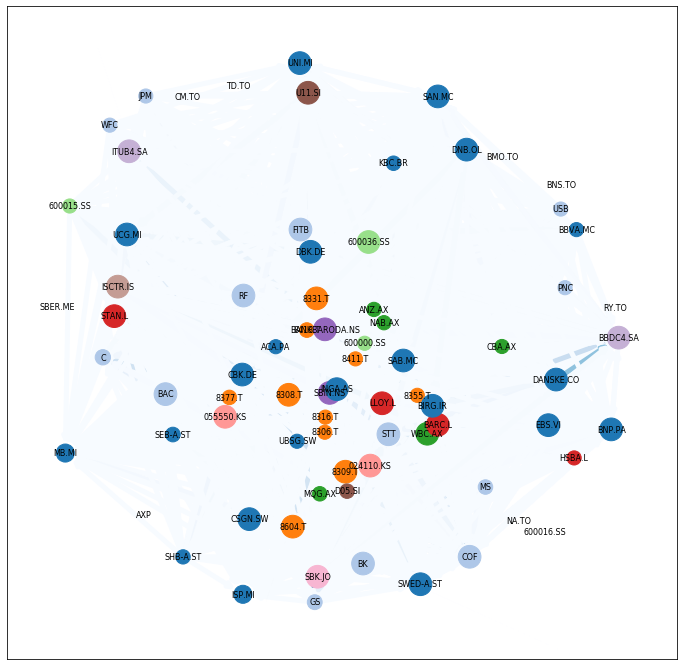

Date: 2019-12-31
Method: DAG


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

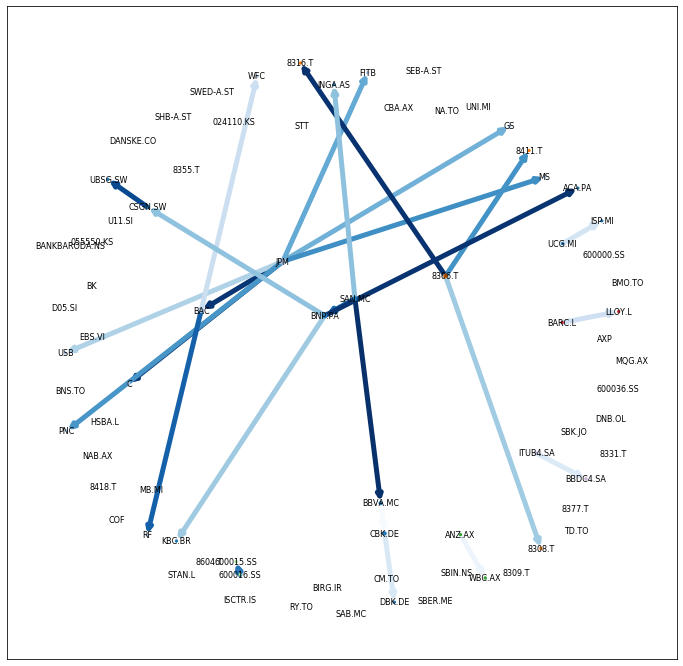

Date: 2020-03-31
Method: NS


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

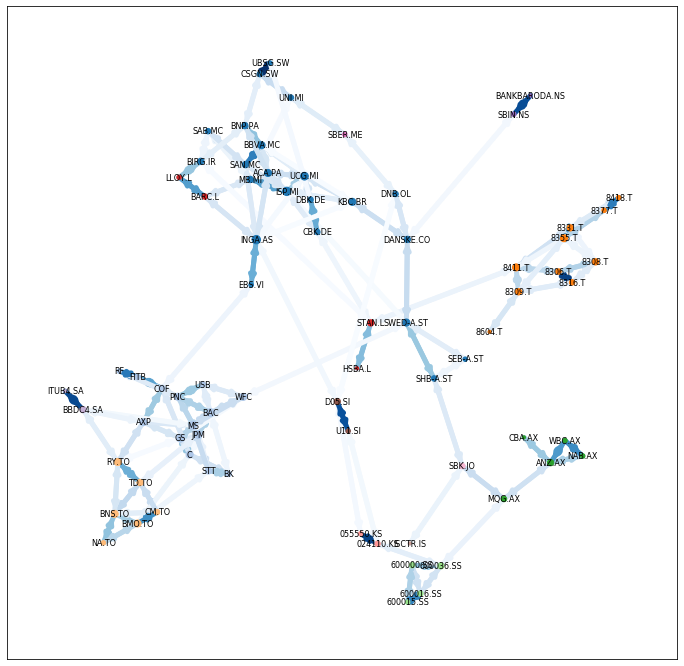

Date: 2020-03-31
Method: SPACE


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

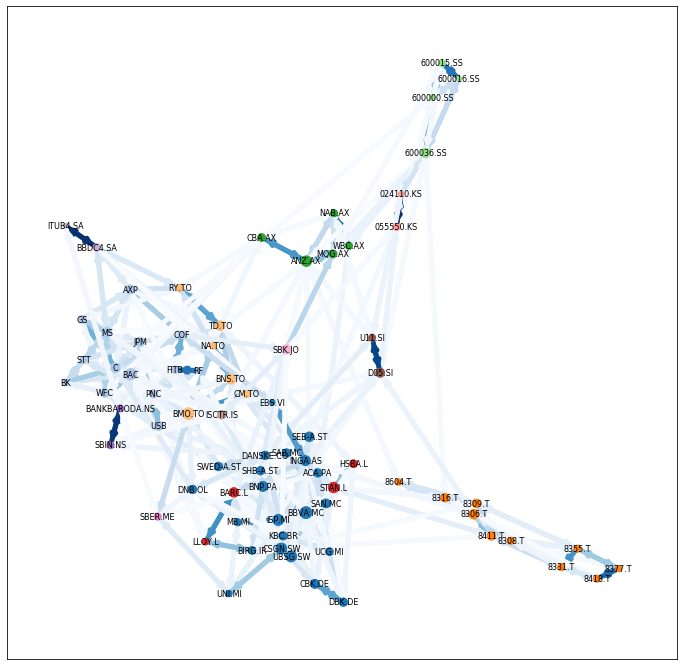

Date: 2020-03-31
Method: GLASSO


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

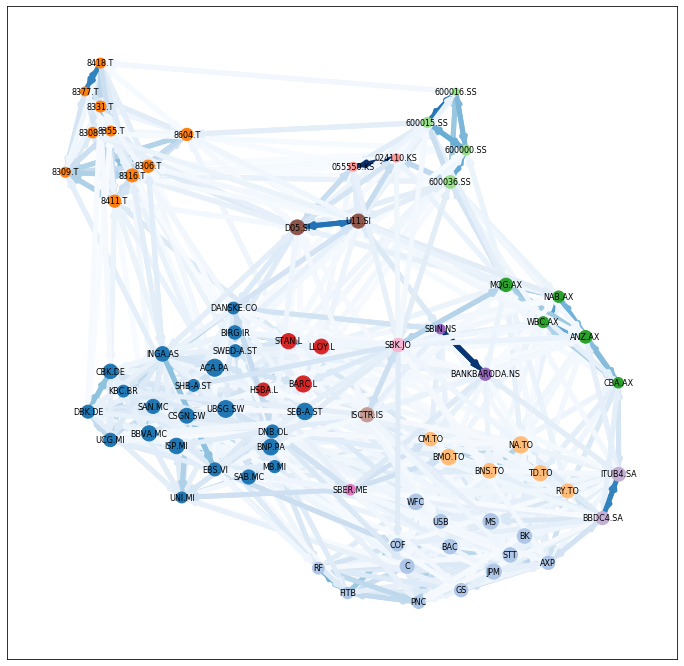

Date: 2020-03-31
Method: DY


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

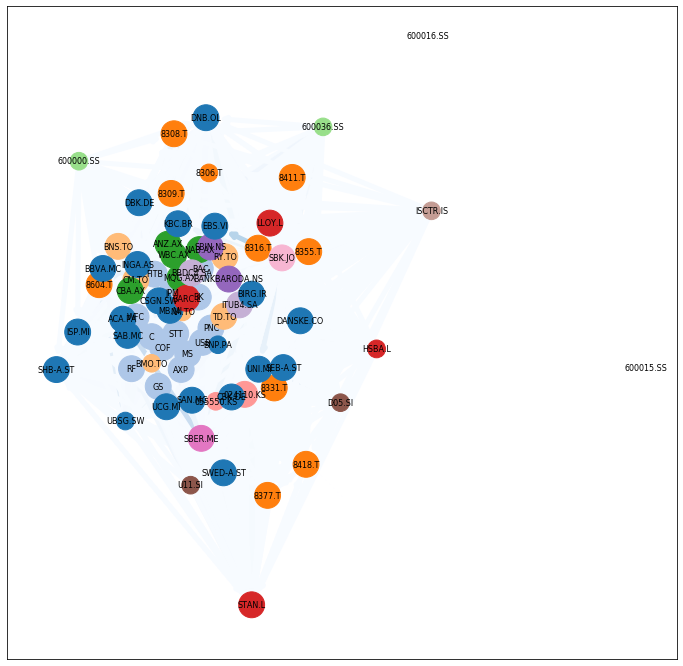

Date: 2020-03-31
Method: DAG


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

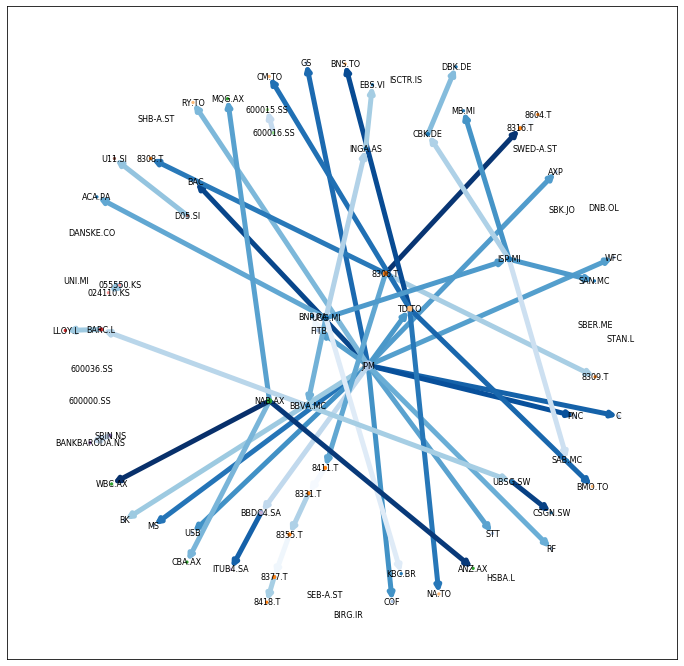

Date: 2020-06-30
Method: NS


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

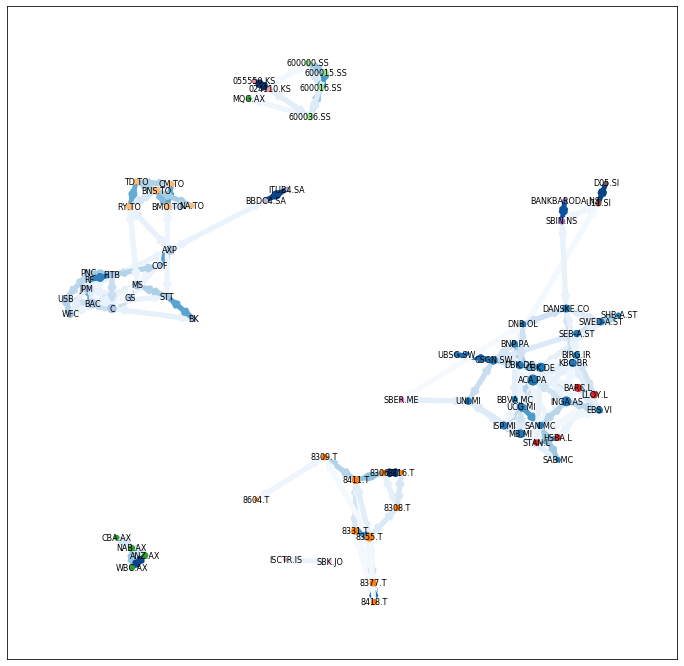

Date: 2020-06-30
Method: SPACE


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

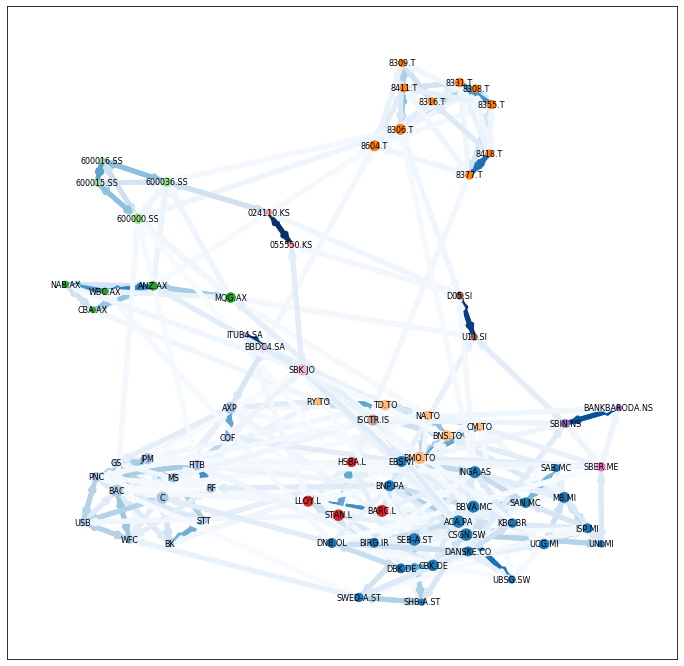

Date: 2020-06-30
Method: GLASSO


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

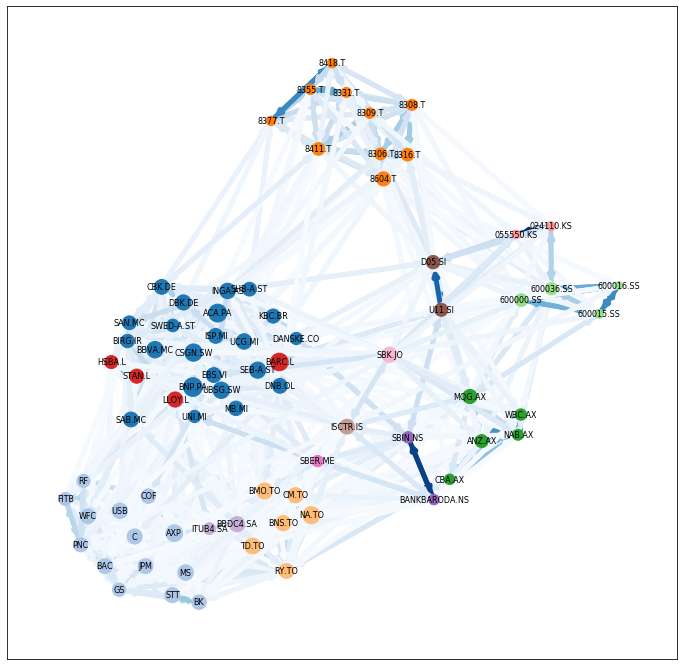

Date: 2020-06-30
Method: DY


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

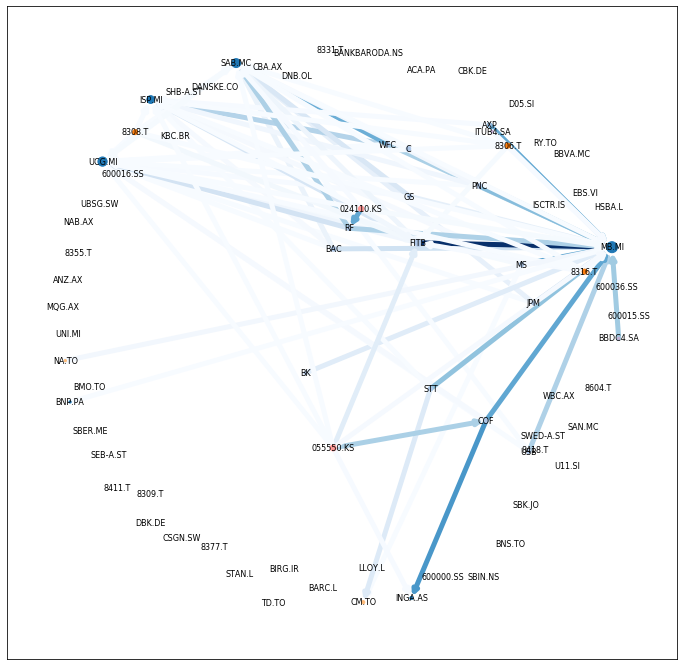

Date: 2020-06-30
Method: DAG


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

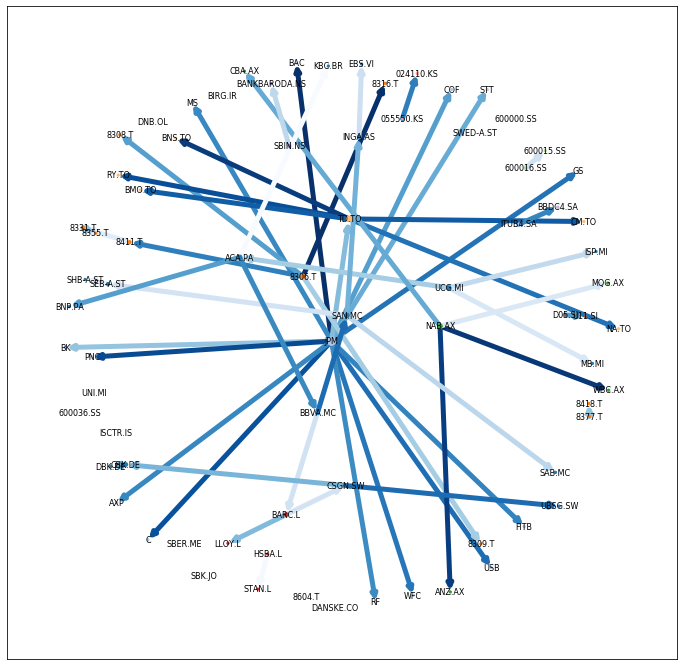

Date: 2020-09-30
Method: NS


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

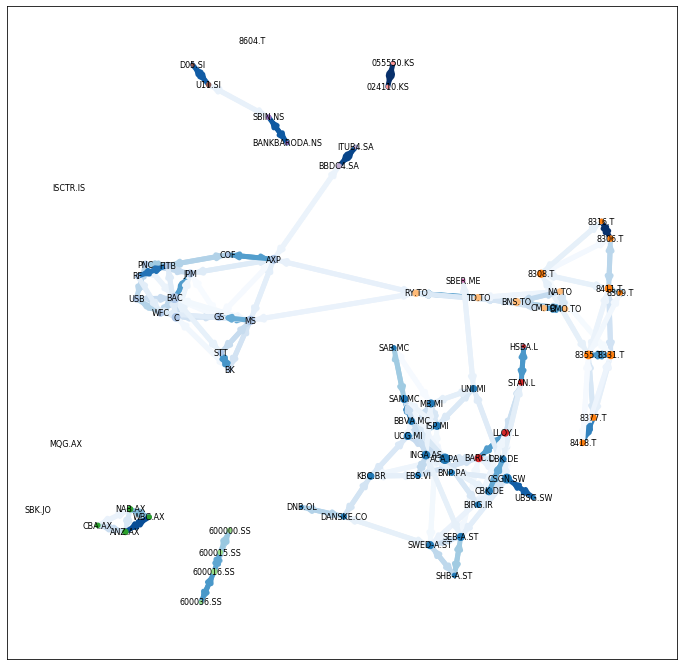

Date: 2020-09-30
Method: SPACE


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

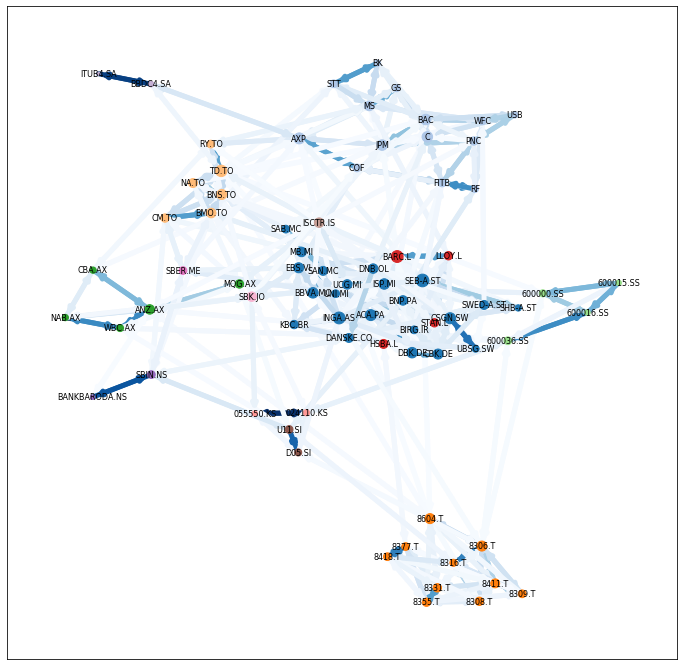

Date: 2020-09-30
Method: GLASSO


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

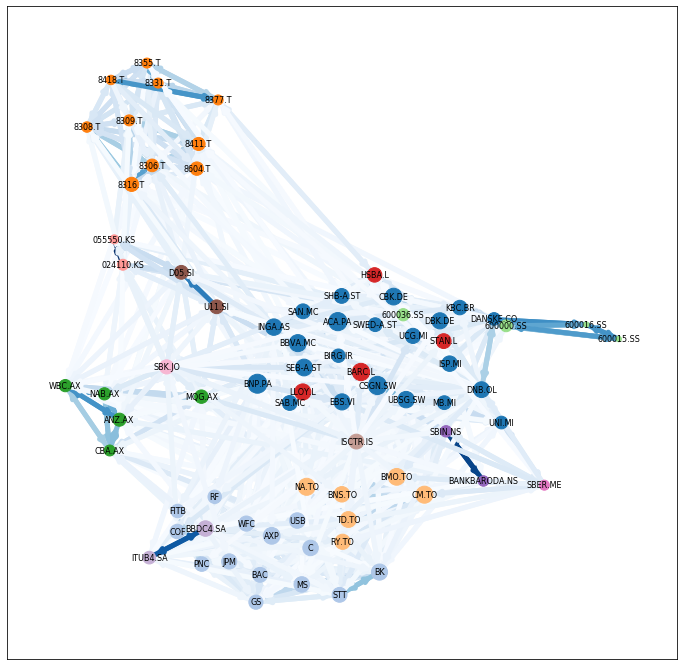

Date: 2020-09-30
Method: DY


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

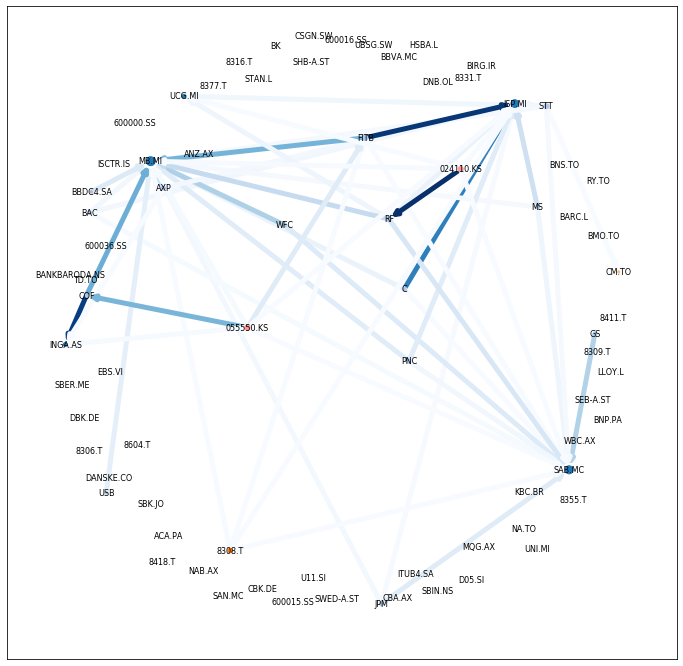

Date: 2020-09-30
Method: DAG


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

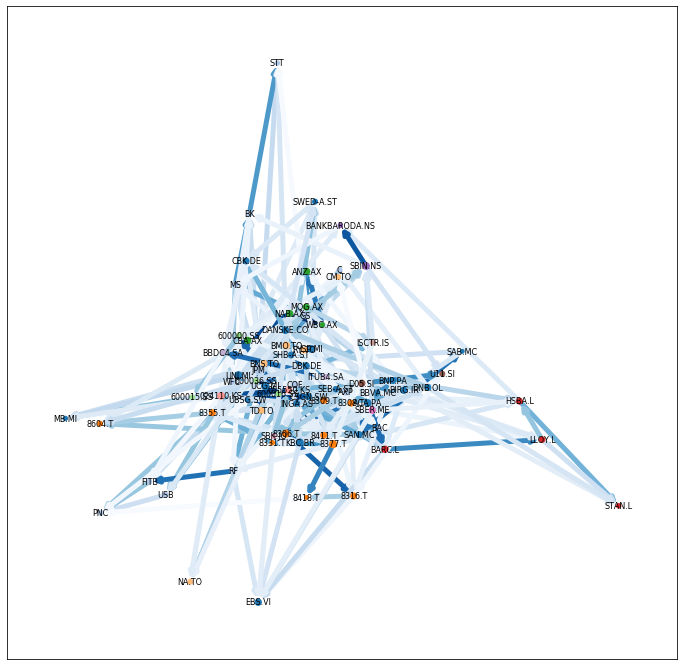

Date: 2020-12-31
Method: NS


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

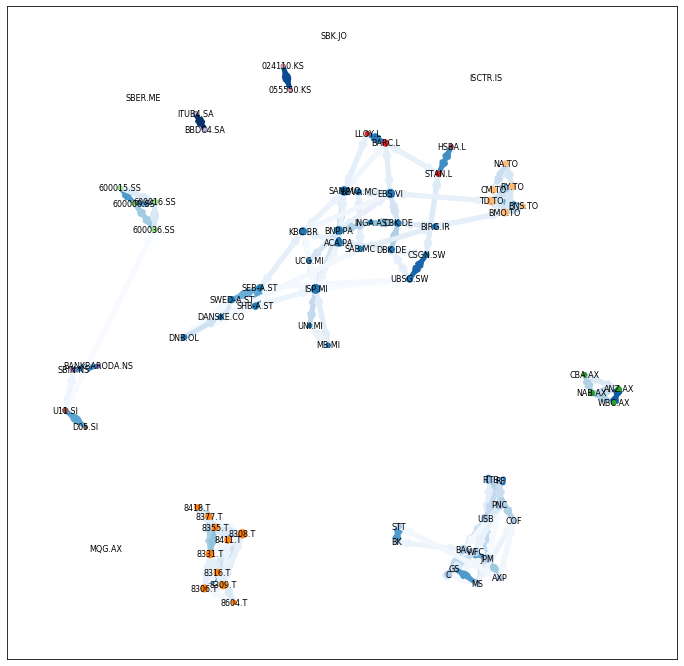

Date: 2020-12-31
Method: SPACE


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

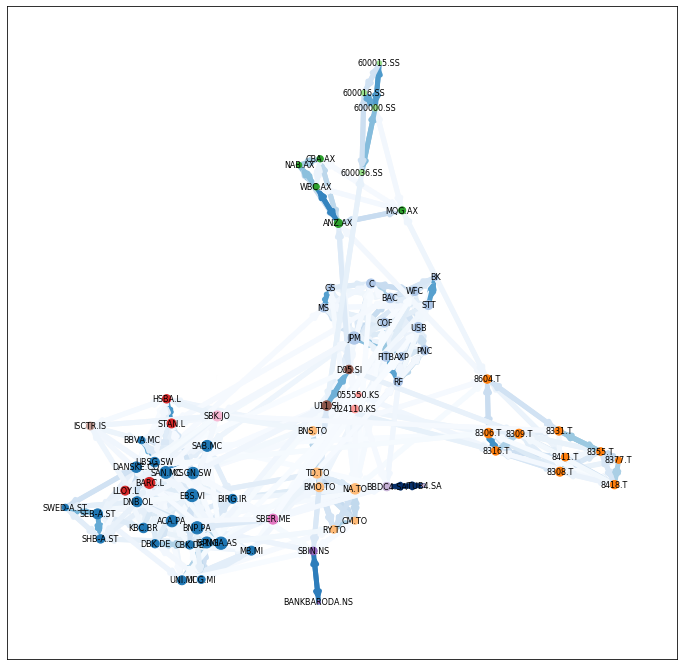

Date: 2020-12-31
Method: GLASSO


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

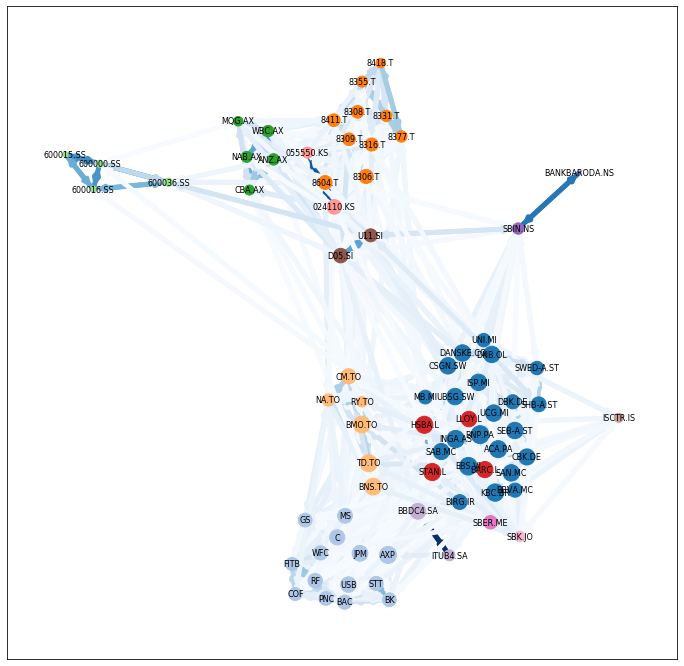

Date: 2020-12-31
Method: DY


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

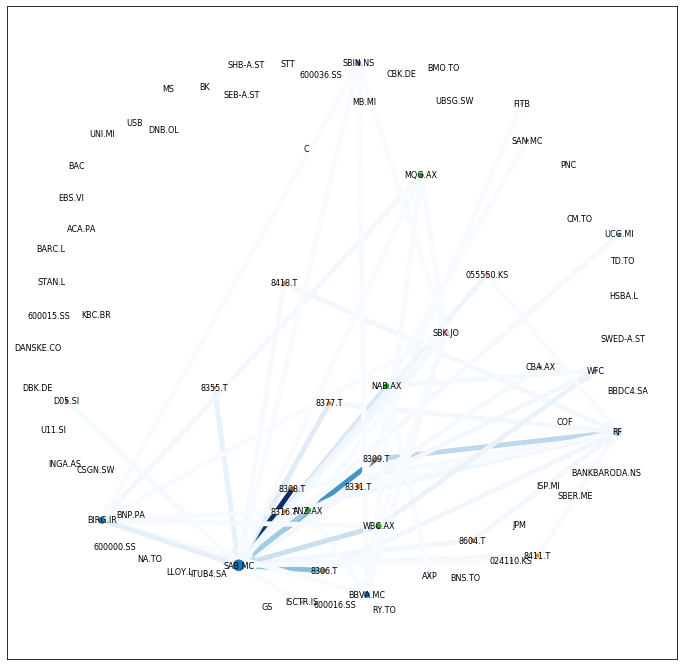

Date: 2020-12-31
Method: DAG


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

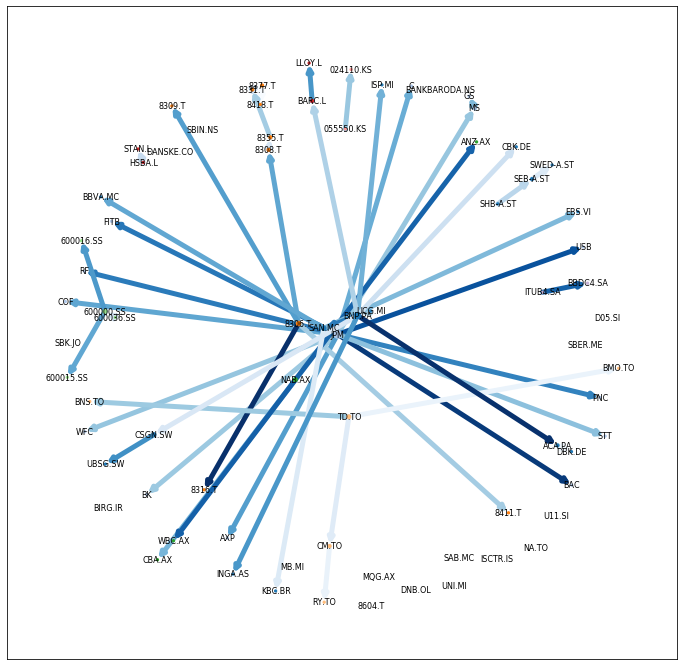

In [22]:
# Parameters
ts_type = "return"

# Iterables
#dates = ["2019-12-31","2020-03-16","2020-03-31","2020-06-30","2020-09-30","2020-12-23"]
dates = ["2019-12-31","2020-03-31","2020-06-30","2020-09-30","2020-12-31"]
methods = ['NS','SPACE','GLASSO','DY','DAG']

for date in dates:

    for method in methods:
        
        print("Date: {}".format(date))

        network_viz_general(date,method,ts_type,var_names,country_colors, base_path, data_type)

# Sensitivity analysis

## Window size

In [23]:
# Parameters
date = "2020-12-31"
ts_type = "return"
base_path = "./Data/Large_network/Estimated_networks/largenet_"
data_type = "largenet"
window_sizes = [100] #[100,50]

# Iterables
methods = ['NS','SPACE','GLASSO','DY','DAG'] #

# Create dictionary to store the outputs
networks = {}

for method in methods:
    
    networks[method] = network_preprocessing_sensitivity_window_size(date,method,
                                                                     ts_type,base_path,window_sizes)

In [24]:
# rel_diffs = {}
# for method in methods:
    
#     rel_diffs[method] = {'150_{}'.format(window_sizes[0]):relative_frobenius_norm_change(networks[method][0],
#                                                                                          networks[method][1]),
#                         '150_{}'.format(window_sizes[1]):relative_frobenius_norm_change(networks[method][0],
#                                                                                          networks[method][2]),
#                         '{}_{}'.format(window_sizes[0],window_sizes[1]):relative_frobenius_norm_change(networks[method][1],
#                                                                                          networks[method][2])}

### Weighted version

In [25]:
rel_diffs = {}
for method in methods:
    
    result = relative_frobenius_norm_change(networks[method][0],networks[method][1])
    
    rel_diffs[method] = {'150_{}'.format(window_sizes[0]):round(result,2)}

In [26]:
rel_diffs

{'NS': {'150_100': 0.4},
 'SPACE': {'150_100': 0.37},
 'GLASSO': {'150_100': 0.3},
 'DY': {'150_100': 0.99},
 'DAG': {'150_100': 0.62}}

### Unweighted version

In [27]:
# Create dictionary to store the outputs
unweighted_networks = {}

for method in methods:
    
    larger_window = networks[method][0]
    smaller_window = networks[method][1]
    
    # Convert to unweighted
    larger_window[larger_window != 0] = 1
    smaller_window[smaller_window != 0] = 1
    
    unweighted_networks[method] = (larger_window,smaller_window)

In [28]:
unweighted_rel_diffs = {}
for method in methods:
    
    result = relative_frobenius_norm_change(unweighted_networks[method][0],
                                            unweighted_networks[method][1])
    
    unweighted_rel_diffs[method] = {'150_{}'.format(window_sizes[0]):round(result,2)}

In [29]:
unweighted_rel_diffs

{'NS': {'150_100': 0.69},
 'SPACE': {'150_100': 0.77},
 'GLASSO': {'150_100': 0.63},
 'DY': {'150_100': 1.14},
 'DAG': {'150_100': 0.65}}

### Visual comparison

In [30]:
def quick_network_viz_from_adj_mat(mat,var_names, color_map,method,window_size):
    
    # Convert it into networkX object
    G = nx.from_numpy_matrix(mat, create_using=nx.DiGraph)

    label_dict = {}

    for i in range(0,len(var_names)):
        label_dict[i] = var_names[i]

    # Relabel network
    G = nx.relabel_nodes(G, label_dict)

    # Get edge weights
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())


    # Parameters
    plt.rcParams['figure.figsize'] = (12,12)

    # Get degrees
    degree_demirer = dict(G.degree)

    # Draw network
    nx.draw_networkx(G,
                         #nodelist=degree_mcc_network.keys(),
                         node_size=[v * 5 for v in degree_demirer.values()],
                         #node_color=colors,
                         font_size=8, node_color=color_map,
                     edgelist=edges,
                     edge_color=weights,
                     width=5.0, edge_cmap=plt.cm.Blues,
                         with_labels=True)
    
    
    plt.savefig('./Figures/sensitivity_windowsize_{}_{}.pdf'.format(window_size,method))

    plt.show()

NS
Window size: 150


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

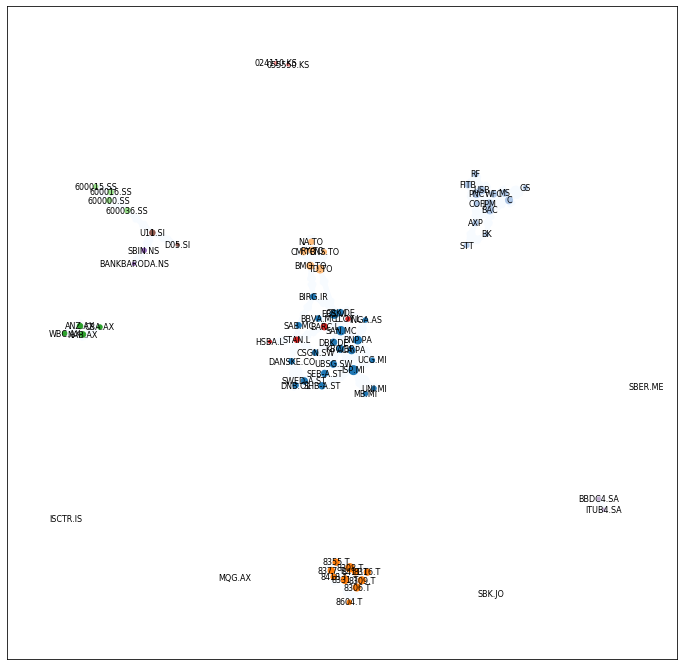

Window size: 100


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

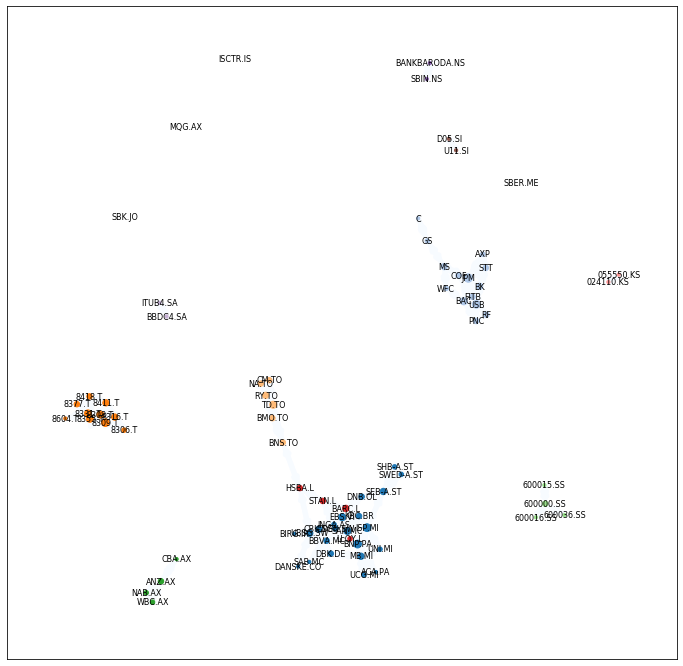

SPACE
Window size: 150


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

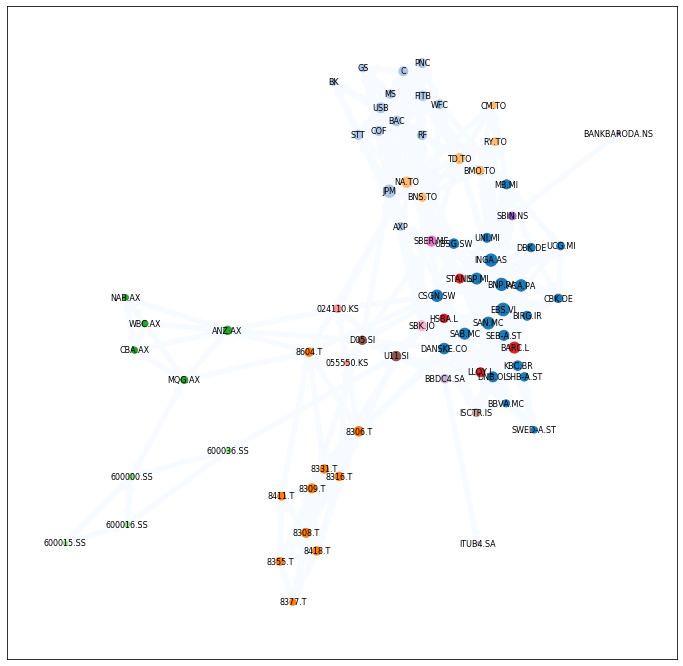

Window size: 100


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

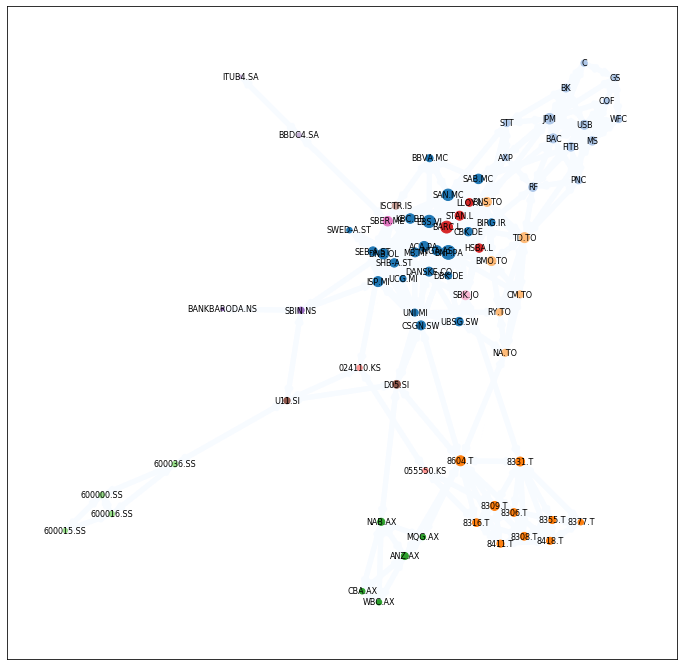

GLASSO
Window size: 150


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

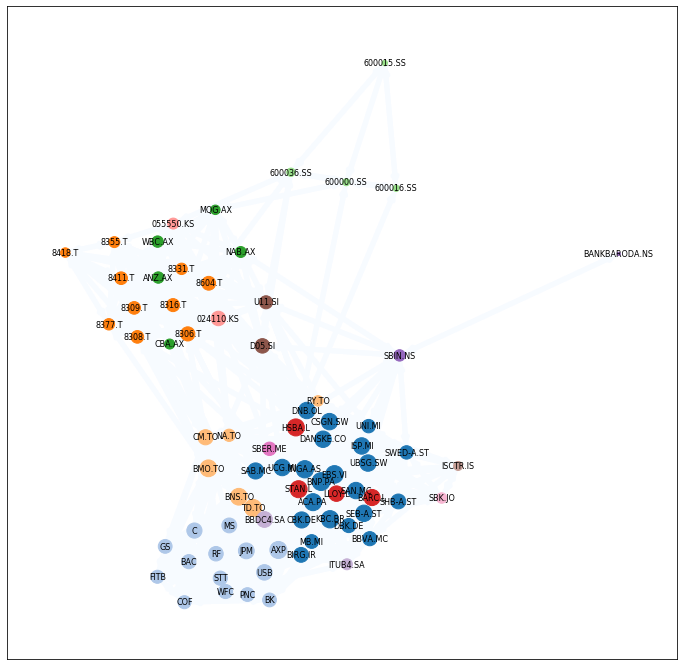

Window size: 100


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

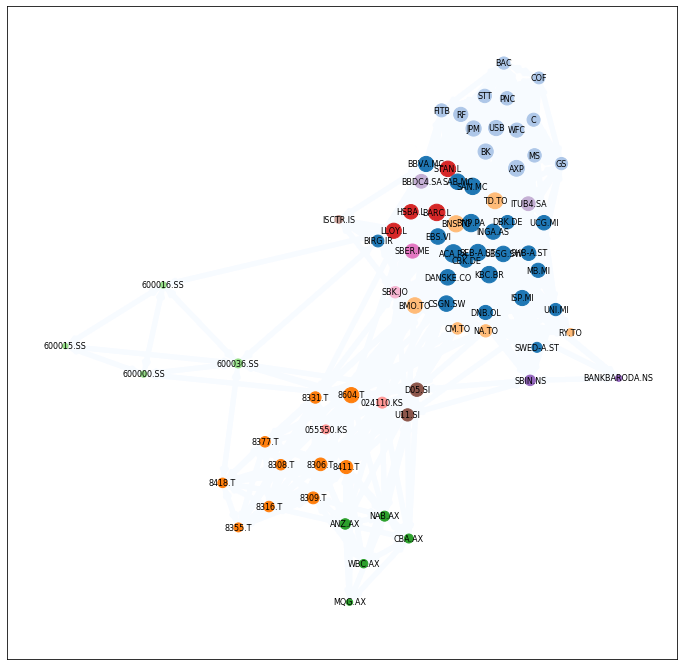

DY
Window size: 150


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

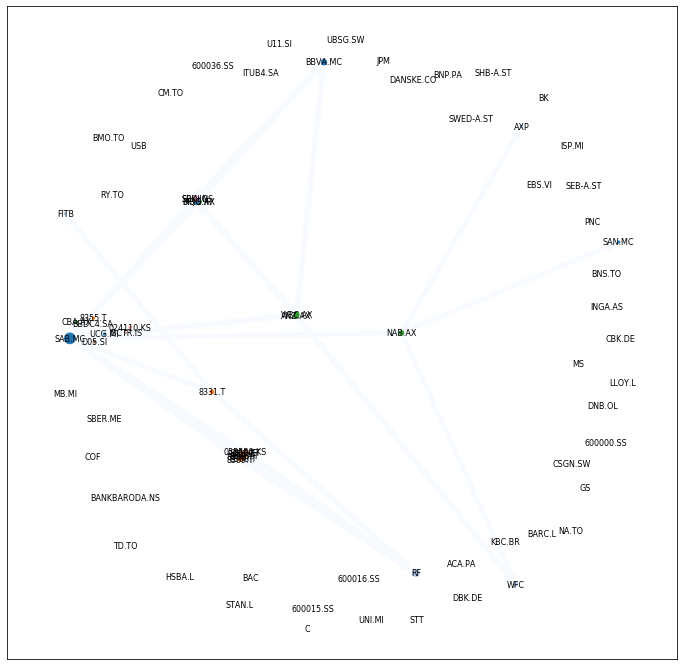

Window size: 100


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

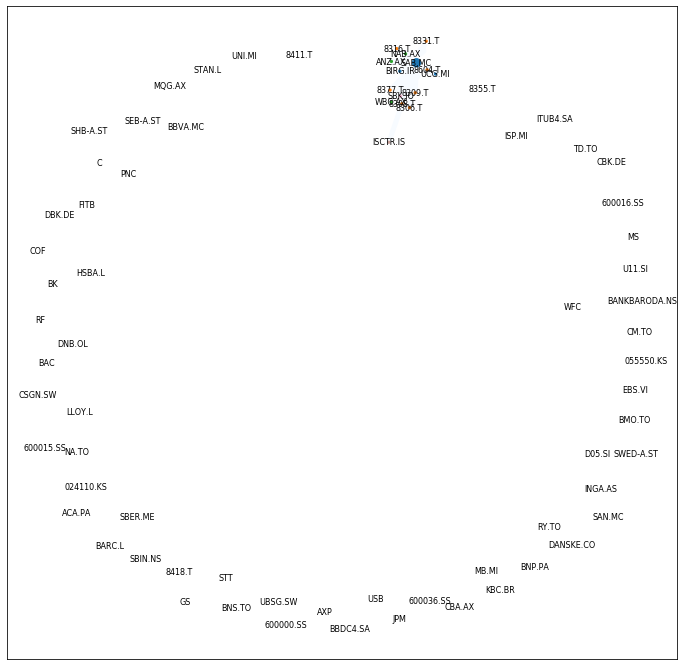

DAG
Window size: 150


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

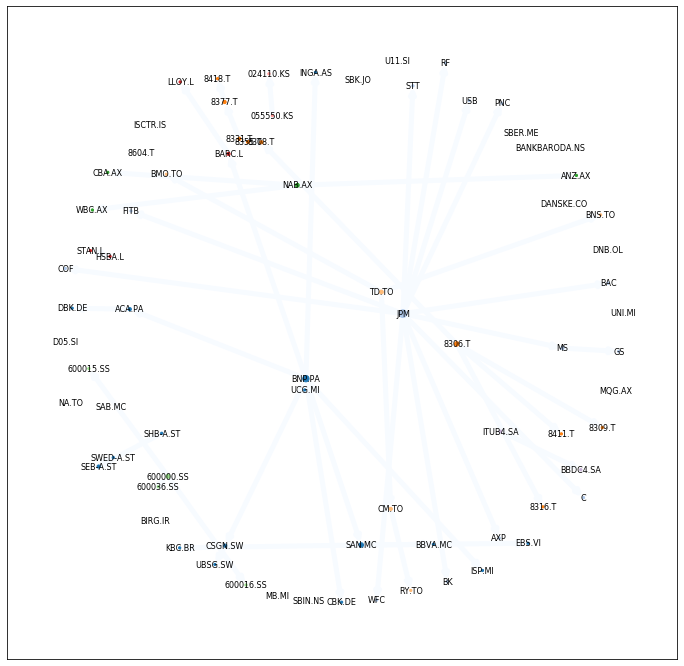

Window size: 100


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

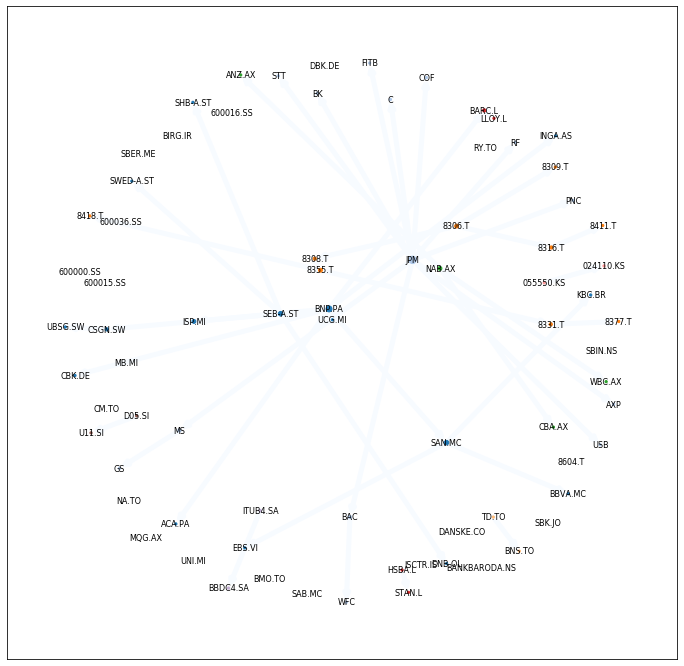

In [31]:
for method in methods:
    
    print(method)
    
    print("Window size: 150")
    quick_network_viz_from_adj_mat(networks[method][0],var_names,country_colors,
                                  method,'150')
    
    print("Window size: 100")
    quick_network_viz_from_adj_mat(networks[method][1],var_names,country_colors,
                                  method,'100')

# Support

In [45]:
label_dict = {}

for i in range(0,len(var_names)):
    label_dict[i] = var_names[i]
    
# Relabel network
G = nx.relabel_nodes(G, label_dict)

In [46]:
# Get edge weights
edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())

In [47]:
# Customize ForceAtlas2 algorithm
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=0.2, #1.0,

                        # Log
                        verbose=True)

In [48]:
# Parameters
plt.rcParams['figure.figsize'] = (12,12)

# Get degrees
degree_demirer = dict(G.degree)

#node_pos = forceatlas2.forceatlas2_networkx_layout(G, niter=1000)
node_pos = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)

100%|██████████| 2000/2000 [00:00<00:00, 2476.97it/s]

BarnesHut Approximation  took  0.21  seconds
Repulsion forces  took  0.39  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.08  seconds


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

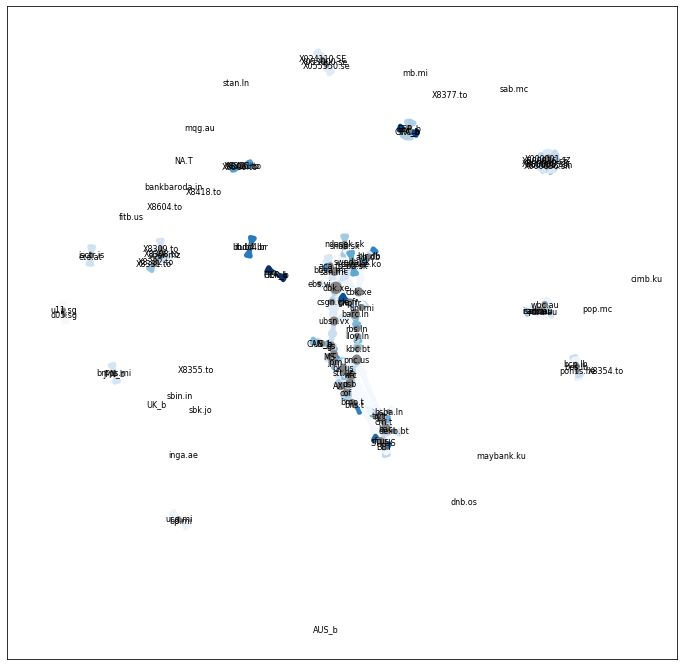

In [49]:
# Draw network
nx.draw_networkx(G,node_pos,
                     #nodelist=degree_mcc_network.keys(),
                     node_size=[v * 8 for v in degree_demirer.values()],
                     #node_color=colors,
                     font_size=8, node_color='grey',
                 edgelist=edges,
                 edge_color=weights,
                 width=5.0, edge_cmap=plt.cm.Blues,
                     with_labels=True)

plt.savefig('./Figures/Demirer_network_{}_{}_{}.pdf'.format(ts_type,method,date),dpi = 120)

In [52]:
# equivalently
GI = igraph.Graph.TupleList(G.edges(), directed=False)
layout = forceatlas2.forceatlas2_igraph_layout(GI, pos=None, iterations=2000)
igraph.plot(GI).show()

100%|██████████| 2000/2000 [00:00<00:00, 3438.58it/s]


BarnesHut Approximation  took  0.16  seconds
Repulsion forces  took  0.26  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.07  seconds


Method: NS


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

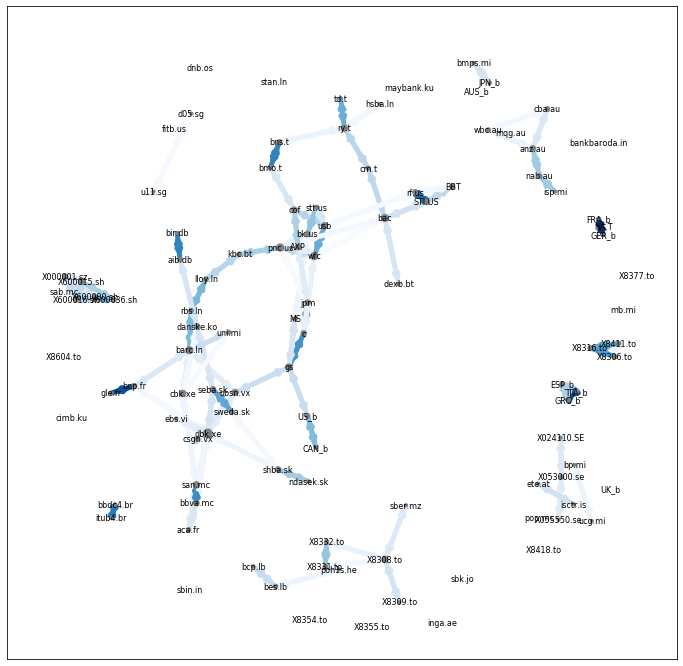

Method: DY_Lasso


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

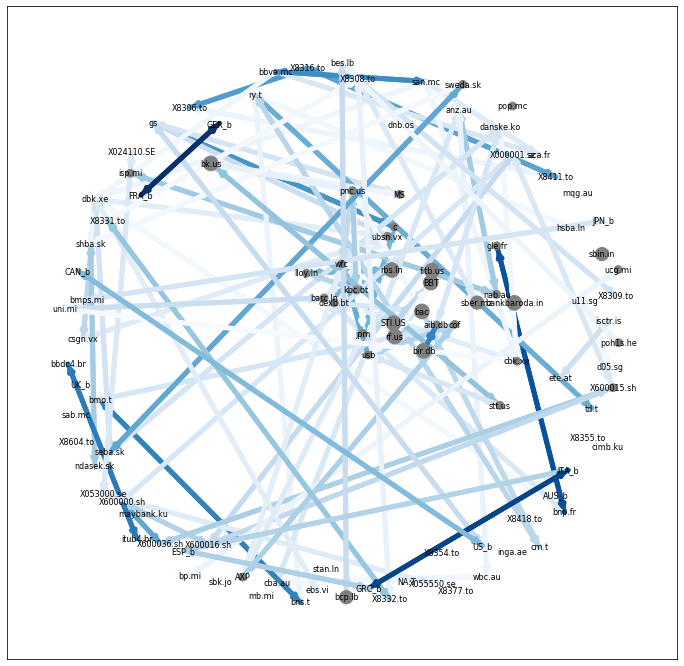

In [53]:
# Iterable (Methods to check)
methods = ["NS","DY_Lasso"]

# Other parameters
date = "2008-09-15"
ts_type = "volatility"

for method in methods:
    
    print("Method: {}".format(method))
    
    # Import network
    G = network_preprocessing(date,method,ts_type)
    
    label_dict = {}

    for i in range(0,len(var_names)):
        label_dict[i] = var_names[i]

    # Relabel network
    G = nx.relabel_nodes(G, label_dict)
    
    
    # Parameters
    plt.rcParams['figure.figsize'] = (12,12)

    # Get degrees
    degree_demirer = dict(G.degree)

    # Draw network
    nx.draw_networkx(G,
                         #nodelist=degree_mcc_network.keys(),
                         node_size=[v * 5 for v in degree_demirer.values()],
                         #node_color=colors,
                         font_size=8, node_color='grey',
                     edgelist=edges,
                     edge_color=weights,
                     width=5.0, edge_cmap=plt.cm.Blues,
                         with_labels=True)

    plt.savefig('./Figures/Demirer_network_{}_{}_{}.pdf'.format(ts_type,method,date),dpi = 120)
    plt.show()

In [44]:
# # Really naive example
# nx.draw(G, pos=nx.spring_layout(G))